In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()

In [2]:
subj = 'EL018'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos

path_patient_analysis = 'y:\\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
# EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
######### Load data
rerun = 0
if os.path.isfile(file_con):
    # con_trial
    con_trial = pd.read_csv(file_con)

# load hypnogram
file_hypno = path_patient_analysis + '/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
len(np.unique(stimlist_hypno.stim_block))

print(len(stimlist_hypno[stimlist_hypno.Prot=='BrainMapping']))
print(len(stimlist_hypno[stimlist_hypno.Prot=='InputOutput']))
print(len(stimlist_hypno[stimlist_hypno.Prot=='PairedPulse']))

print(len(stimlist_hypno[stimlist_hypno.sleep==0])/len(stimlist_hypno[stimlist_hypno.sleep<5]))
print(len(stimlist_hypno[(stimlist_hypno.sleep>0)&(stimlist_hypno.sleep<4)])/len(stimlist_hypno[stimlist_hypno.sleep<5]))
print(len(stimlist_hypno[stimlist_hypno.sleep==4])/len(stimlist_hypno[stimlist_hypno.sleep<5]))


In [3]:

##all
cond_vals = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]

In [4]:
if platform.system() == 'Windows':
    # sep = ','
    path = 'y:\eLab\Patients\\'  # + subj
    CR_color = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\Analysis\BrainMapping\CR_color.xlsx",
                             header=0)
    regions = pd.read_excel("Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\Across\elab_labels.xlsx",
                            sheet_name='regions',
                            header=0)

    # path_patient    = 'E:\PhD\EL_experiment\Patients\\'+subj # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
else:  # 'Darwin' for MAC
    path = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'  # + subj
    CR_color = pd.read_excel("/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/Analysis/BrainMapping/CR_color.xlsx",
                             header=0)
    regions = pd.read_excel("/Volumes/EvM_T7/PhD/EL_experiment/Patients/all/elab_labels.xlsx", sheet_name='regions',
                            header=0)

sep = ';'
color_regions = regions.color.values
C = regions.label.values
cond_folder = 'CR'

In [1904]:
#EEG_CR_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_'+cond_folder+'.npy'
#EEG_CR = np.load(EEG_CR_file)
#stimlist = pd.read_csv(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\Stimlist_'+cond_folder+'.csv')

EEG_CR = np.load(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.npy')
stimlist = pd.read_csv(
    path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\stimlist_' + cond_folder + '.csv')


###  NEW CLUSTERING, USING SURR

In [1698]:
def get_GT_trials(trials, real=1, t_0=1, Fs=500, w=0.25, n_cluster=2):
    # t_0 stimulation time in epoched data, changed in surrogate data
    # trials = EEG_resp[rc, stimNum_all, :], shape (n,2000)
    # 1. z-score trials and get LL for t_onset and t_max
    EEG_trial = ff.bp_filter(trials, 1,40, Fs)
    #EEG_trial = stats.zscore(EEG_trial, axis=1)
    resp_mean = np.nanmean(EEG_trial, 0) ## ff.lp_filter(np.nanmean(bf.zscore_CCEP(trials), 0), 40, Fs)
    # LL_mean = LLf.get_LL_all(np.expand_dims(trials, 0), Fs, w)
    # LL_mean = np.expand_dims(np.mean(LL_mean,1),0)
    LL_mean = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_mean, 0), 0), Fs, w)
    # where LL is the highest
    t_resp = np.argmax(LL_mean[0, 0, int((t_0 + w / 2) * Fs):int((t_0 + 0.5 - w / 2) * Fs)]) / Fs
    if real:
        thr = np.percentile(np.concatenate([LL_mean[0, 0, int((w / 2) * Fs):int((t_0 - w / 2) * Fs)],
                                            LL_mean[0, 0, int((3) * Fs):int((4 - w / 2) * Fs)]]),
                            99)  # LL_resp[0, 0, int((t_0+0.5) * Fs):] = 0 * Fs):] = 0
        LL_t = np.array(LL_mean[0, 0, :int((t_0 + 0.5) * Fs)] > thr) * 1
        t_resp_all = sf.search_sequence_numpy(LL_t, np.ones((int((w + 0.08) * Fs),)))
        if len(t_resp_all) > 0:
            t_onset = t_resp_all[0] / Fs - t_0 + w / 2
            r = 1
            if (t_onset < 0.001) | (t_onset > 0.5):
                t_onset = 0
        else:
            r = 0
            t_onset = 0
    else:  # surr
        r = 10
        t_onset = 0
        thr = 0
    # cluster trials based on specific window (where highest LL is)
    EEG_trial = stats.zscore(EEG_trial, axis=1)
    cc, y = Cf.ts_cluster(
        EEG_trial[:, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w) * Fs)], n=n_cluster,
        method='euclidean')
    # p_CC = np.corrcoef(cc[0], cc[1])[0, 1]  # pearson correlation of two clusters
    M_GT = np.zeros((3, trials.shape[-1]))
    M_GT[0, :] = ff.lp_filter(np.nanmean(EEG_trial, 0), 45, Fs)
    for c in range(n_cluster):
        M_GT[c + 1, :] = ff.lp_filter(np.nanmean(EEG_trial[y == c, :], 0), 45, Fs)
    p_CC = np.corrcoef(M_GT[1, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + 2 * w) * Fs)],
                       M_GT[2, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + 2 * w) * Fs)])[0, 1]
    LL_CC = LLf.get_LL_all(np.expand_dims(M_GT[1:,int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w) * Fs)], 0), Fs, w)
    LL_CC = np.max(LL_CC[0,:,:],1)
    return [r, t_onset, t_resp], LL_mean[0, 0], p_CC, M_GT, y, thr, LL_CC

In [1758]:
def get_GT_trials(trials, real=1, t_0=1, Fs=500, w=0.25, n_cluster=2):
    # t_0 stimulation time in epoched data, changed in surrogate data
    # trials = EEG_resp[rc, stimNum_all, :], shape (n,2000)
    # 1. z-score trials and get LL for t_onset and t_max
    EEG_trial = ff.bp_filter(trials, 1,40, Fs)
    #EEG_trial = stats.zscore(EEG_trial, axis=1)
    resp_mean = ff.lp_filter(np.nanmean(EEG_trial, 0),40,Fs)  ## ff.lp_filter(np.nanmean(bf.zscore_CCEP(trials), 0), 40, Fs)
    LL_mean = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_mean, 0), 0), Fs, w)
    # where LL is the highest
    t_resp = np.argmax(LL_mean[0, 0, int((t_0 + w / 2) * Fs):int((t_0 + 0.5 - w / 2) * Fs)]) / Fs
    if real:
        thr = np.percentile(np.concatenate([LL_mean[0, 0, int((w / 2) * Fs):int((t_0 - w / 2) * Fs)],
                                            LL_mean[0, 0, int(3 * Fs):int((4 - w / 2) * Fs)]]),
                            99)  # LL_resp[0, 0, int((t_0+0.5) * Fs):] = 0 * Fs):] = 0
        LL_t = np.array(LL_mean[0, 0, :int((t_0 + 0.5) * Fs)] > thr) * 1
        t_resp_all = sf.search_sequence_numpy(LL_t, np.ones((int((w + 0.08) * Fs),)))
        if len(t_resp_all) > 0:
            t_onset = t_resp_all[0] / Fs - t_0 + w / 2
            r = 1
            if (t_onset < 0.001) | (t_onset > 0.5):
                t_onset = 0
        else:
            r = 0
            t_onset = 0
    else:  # surr
        r = 10
        t_onset = 0
        thr = 0
    # cluster trials based on specific window (where highest LL is)
    EEG_trial = EEG_trial/np.repeat(np.expand_dims(np.max(trials,1),0),2000,0).T # tats.zscore(EEG_trial, axis=1)
    cc, y = Cf.ts_cluster(
        EEG_trial[:, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w) * Fs)], n=n_cluster,
        method='euclidean')
    # p_CC = np.corrcoef(cc[0], cc[1])[0, 1]  # pearson correlation of two clusters
    M_GT = np.zeros((3, trials.shape[-1]))
    M_GT[0, :] = ff.lp_filter(np.nanmean(trials, 0), 30, Fs)
    for c in range(n_cluster):
        M_GT[c + 1, :] = ff.lp_filter(np.nanmean(trials[y == c, :], 0), 30, Fs)
    p_CC = np.corrcoef(M_GT[1, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + 2 * w) * Fs)],
                       M_GT[2, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + 2 * w) * Fs)])[0, 1]
    LL_CC = LLf.get_LL_all(np.expand_dims(M_GT[1:, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w) * Fs)], 0), Fs, w)
    LL_CC = np.max(LL_CC[0, :, :], 1)
    return [r, t_onset, t_resp], LL_mean[0, 0], p_CC, M_GT, y, thr, LL_CC


In [1713]:
LL_CC = LLf.get_LL_all(np.expand_dims(M_GT[1:, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w) * Fs)], 0), Fs, w)

In [139]:
import significance_funcs as sf
import Cluster_func as Cf

In [375]:
colors_GT = np.zeros((3,3))
colors_GT[1,:] = color_elab[0]
colors_GT[2,:] = color_elab[2]

In [1254]:
dat_FP = sig_con[(sig_con.Sig_CC_LL==1)& (sig_con.Sig_LL==0)]
dat_FN = sig_con[(sig_con.Sig_CC_LL==0)& (sig_con.Sig_LL==1)]
dat_TN = sig_con[(sig_con.Sig_CC_LL==0)& (sig_con.Sig_LL==0)]
dat_TP = sig_con[(sig_con.Sig_CC_LL==1)& (sig_con.Sig_LL==1)]
k = -1

In [1891]:
subj

'EL011'

In [1898]:
lists = con_trial[(con_trial['Artefact'] <1) & (con_trial['Chan'] == rc) & (con_trial['Stim'] == sc)]
lists

,Chan,Stim,LL,P2P,LL_onset,Sig,Hour,SleepState,Block,Sleep,Num,Num_block,Date,Artefact,d
31,0.0,7.0,5.754420,441.645840,5.744553,1,15.0,Wake,1.0,0.0,31.0,31.0,20220215.0,0.0,11.46
52,0.0,7.0,6.239811,535.924432,5.732474,1,15.0,Wake,1.0,0.0,52.0,52.0,20220215.0,0.0,11.46
78,0.0,7.0,6.417814,468.636394,6.072809,1,15.0,Wake,1.0,0.0,78.0,78.0,20220215.0,0.0,11.46
8176,0.0,7.0,5.738747,416.391564,5.485380,1,16.0,Wake,2.0,0.0,226.0,76.0,20220215.0,0.0,11.46
8225,0.0,7.0,6.084013,475.893610,6.014103,1,16.0,Wake,2.0,0.0,275.0,125.0,20220215.0,0.0,11.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542465,0.0,7.0,3.367676,357.323989,3.221102,1,12.0,Wake,68.0,0.0,10133.0,89.0,20220218.0,0.0,11.46
542481,0.0,7.0,4.298216,406.292998,4.204396,1,12.0,Wake,68.0,0.0,10149.0,105.0,20220218.0,0.0,11.46
550502,0.0,7.0,3.890478,449.988814,3.143322,1,13.0,Wake,69.0,0.0,10220.0,26.0,20220218.0,0.0,11.46
550540,0.0,7.0,3.220527,238.282112,3.209810,1,13.0,Wake,69.0,0.0,10258.0,64.0,20220218.0,0.0,11.46


In [1899]:
con_trial

,Chan,Stim,LL,P2P,LL_onset,Sig,Hour,SleepState,Block,Sleep,Num,Num_block,Date,Artefact,d
0,0.0,38.0,3.112841,265.986196,2.343089,1,15.0,Wake,1.0,0.0,0.0,0.0,20220215.0,0.0,35.68
1,0.0,40.0,2.724212,240.247410,0.000000,0,15.0,Wake,1.0,0.0,1.0,1.0,20220215.0,-1.0,35.35
2,0.0,19.0,2.371869,242.534783,2.343071,1,15.0,Wake,1.0,0.0,2.0,2.0,20220215.0,0.0,14.23
3,0.0,68.0,1.501889,145.296012,0.000000,0,15.0,Wake,1.0,0.0,3.0,3.0,20220215.0,0.0,75.99
4,0.0,27.0,1.853082,162.626234,0.000000,0,15.0,Wake,1.0,0.0,4.0,4.0,20220215.0,0.0,23.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558571,86.0,85.0,119.101393,13679.636849,0.000000,-1,13.0,Wake,69.0,0.0,10339.0,145.0,20220218.0,2.0,3.50
558572,86.0,47.0,5.375446,283.214409,0.000000,0,13.0,Wake,69.0,0.0,10340.0,146.0,20220218.0,-1.0,65.21
558573,86.0,49.0,3.795502,221.487138,2.978491,0,13.0,Wake,69.0,0.0,10341.0,147.0,20220218.0,0.0,67.77
558574,86.0,27.0,2.703691,98.190826,0.000000,0,13.0,Wake,69.0,0.0,10342.0,148.0,20220218.0,1.0,66.56


In [1901]:
EEG_CR.shape

(84, 2489, 2000)

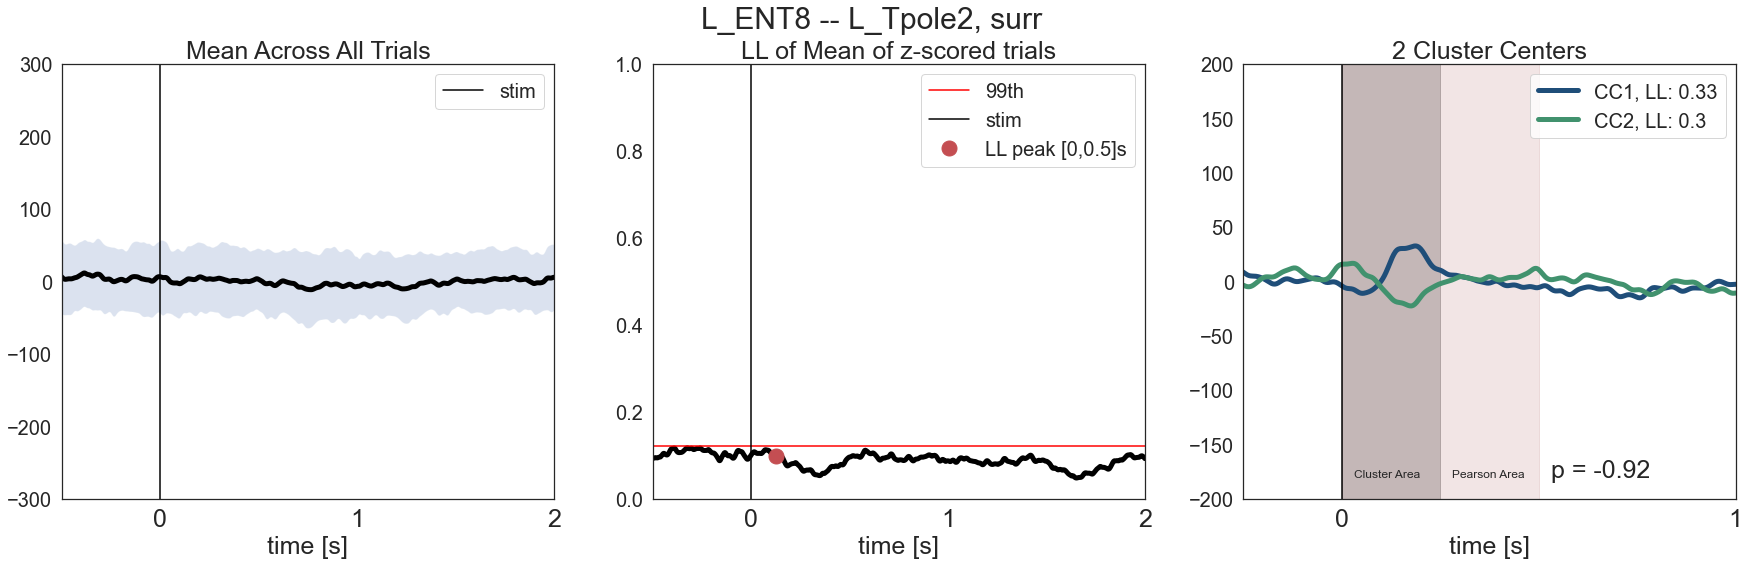

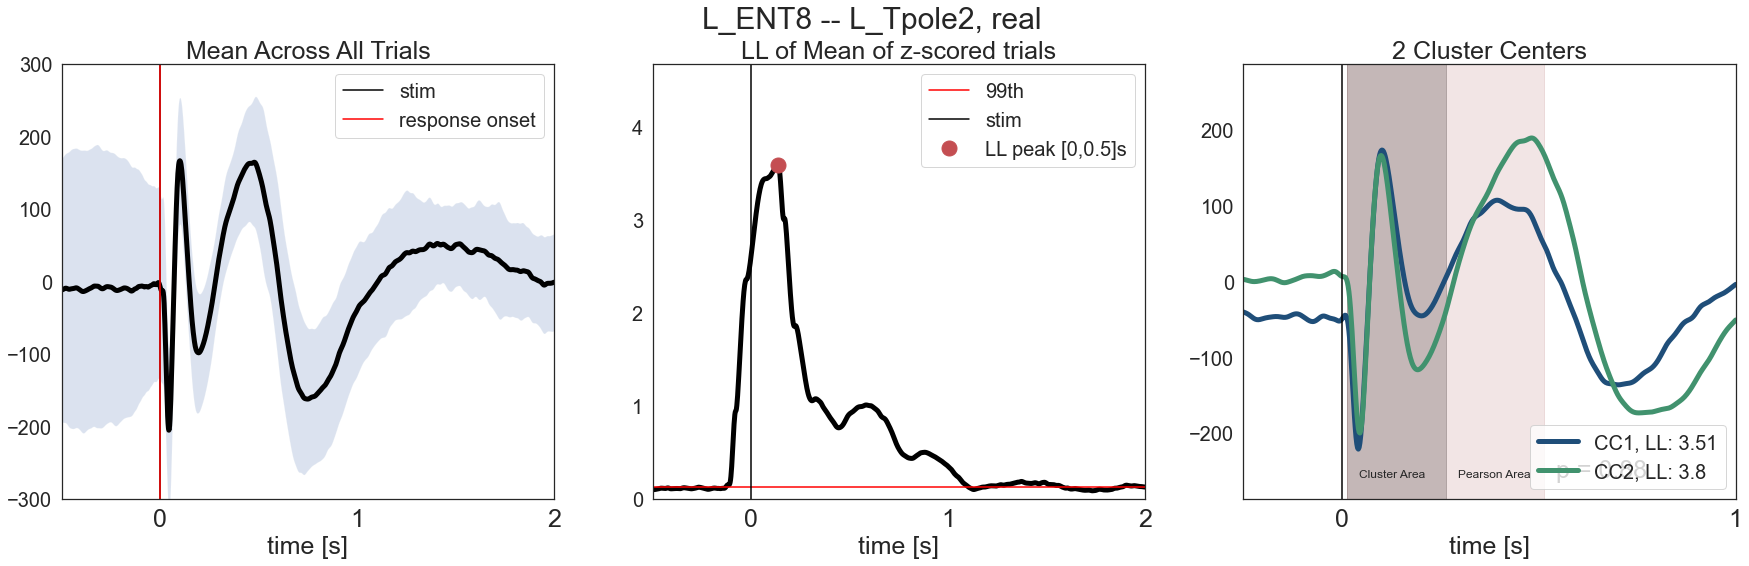

In [1906]:
#k = k+1
sc = 7
rc = 1
#sc = 19 # dat_i.Stim.values[k].astype('int')
#rc = 85 # dat_i.Chan.values[k].astype('int')
for real in [1]:
    if real:
        m = 'real'
        lists = con_trial[(con_trial['Artefact'] <1) & (con_trial['Chan'] == rc) & (con_trial['Stim'] == sc)]
        stimNum_all = lists.Num.values.astype('int')
        n_trials = len(stimNum_all)
        if len(stimNum_all) > 0:
            t_nan = np.where(np.isnan(np.mean(EEG_CR[rc, stimNum_all, :], 1)) * 1)  # [0][0]
            if len(t_nan[0]) > 0:
                stimNum_all = np.delete(stimNum_all, t_nan[0])
            if len(stimNum_all) > 15:
                trials = EEG_CR[rc, stimNum_all, :]
        [r, t_onset, t_resp],LL_mean, p_CC, M_GT, y, thr,LL_CC = get_GT_trials(trials, real=1, t_0=1, Fs=500, w=0.25, n_cluster=2)
    else:
        m = 'surr'
        stim_trials = np.unique(
            con_trial.loc[(con_trial.Stim >= rc - 1) & (con_trial.Stim <= rc + 1), 'Num'].values.astype('int'))
        StimNum = np.unique(con_trial.loc[(con_trial.d > 11) & (con_trial.Artefact == 0) & (
                con_trial.Chan == rc), 'Num'])  # np.random.choice(np.unique(con_trial.Num), size=400)
        StimNum = [i for i in StimNum if i not in stim_trials]
        StimNum = [i for i in StimNum if i not in stim_trials + 1]
        StimNum = [i for i in StimNum if i not in stim_trials - 1]
        StimNum_surr = np.random.choice(StimNum, size=n_trials).astype('int')

        if len(StimNum_surr) > 0:
            t_nan = np.where(np.isnan(np.mean(EEG_CR[rc, StimNum_surr, :], 1)) * 1)  # [0][0]
            if len(t_nan[0]) > 0:
                StimNum_surr = np.delete(StimNum_surr, t_nan[0])
            if len(stimNum_all) > 15:
                trials = EEG_CR[rc, StimNum_surr, :]
                trials[:,0:1000] = EEG_CR[rc, StimNum_surr, 1000:]
                trials[:,1000:] = 0.9*np.flip(EEG_CR[rc, StimNum_surr, 1000:],1)#EEG_CR[rc, StimNum_surr+1, 1000:]
        [r, t_onset, t_resp],LL_mean, p_CC, M_GT, y, thr,LL_CC = get_GT_trials(trials, real=1, t_0=1, Fs=500, w=0.25, n_cluster=2)
    plot_CC_example()

In [1707]:
def plot_CC_example():
    fig = plt.figure(figsize=(30, 8))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style='white')
    plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc]+', '+m, fontsize=30)
    ylim = 300

    gs = fig.add_gridspec(1,3, width_ratios=[2,2,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])

    ax_mean = fig.add_subplot(gs[0, 0])
    plt.plot(x_ax, ff.lp_filter(np.mean(trials,0),45,Fs), color=[0,0,0], linewidth=5)
    st= np.std(ff.lp_filter(trials,30,Fs),0)
    plt.fill_between(x_ax,ff.lp_filter(np.mean(trials,0),45,Fs)-st, ff.lp_filter(np.mean(trials,0),45,Fs)+st, alpha=0.2 )
    ylim = np.max([ylim,1.3*np.max(abs(ff.bp_filter(np.mean(trials,0),1,45,Fs)))])
    plt.xticks([-1, 0, 1, 2, 3], fontsize=25)
    plt.xlabel('time [s]', fontsize=25)
    plt.axvline(0, color=[0,0,0], label='stim')
    plt.title('Mean Across All Trials', fontsize=25)
    plt.xlim([-0.5, 2])
    plt.ylim([-ylim,ylim])
    if r: plt.axvline(t_onset, color=[1,0,0], label='response onset')
    plt.legend(fontsize=20)
    plt.yticks(fontsize=20)


    ax_LL =fig.add_subplot(gs[0, 1],sharex=ax_mean)
    ylim = 1
    plt.plot(x_ax, LL_mean, color=[0,0,0], linewidth=5)
    plt.axhline(thr, color=[1,0,0], label='99th')
    ylim = np.max([ylim, 3*thr, 1.3*LL_mean[int((t_0 +t_resp+ w / 2) * Fs)]])
    plt.axvline(0, color=[0,0,0], label='stim')
    # plt.axvline(t_onset, color=[1,0,0], label='response onset')
    plt.plot(t_resp+w/2, LL_mean[int((t_0 +t_resp+ w / 2) * Fs)], 'ro', markersize=15,label='LL peak [0,0.5]s')

    plt.xticks([-1, 0, 1, 2, 3], fontsize=25)
    plt.xlabel('time [s]', fontsize=25)
    plt.title('LL of Mean of z-scored trials', fontsize=25)
    plt.legend(fontsize=20)
    plt.ylim([0,ylim])
    plt.xlim([-0.5, 2])
    plt.yticks(fontsize=20)

    ax_GT = fig.add_subplot(gs[0, 2])
    ylim = 200
    plt.title('2 Cluster Centers', fontsize=25)
    for i in [1,2]:
        plt.plot(x_ax, M_GT[i], color=colors_GT[i],linewidth=5, label = 'CC'+str(i)+', LL: '+str(np.round(LL_CC[i-1],2)))
        ylim = np.max([ylim, 1.3*np.max(abs( M_GT[i]))])
    plt.xlabel('time [s]', fontsize=25)
    plt.axvspan(t_resp, t_resp+w, color=[0,0,0], alpha=0.2)
    plt.axvspan(t_resp, t_resp+2*w, color=[0.5,0,0], alpha=0.1)

    plt.axvline(0, color=[0,0,0])
    plt.text(t_resp+0.03, -0.9*ylim, 'Cluster Area')
    plt.text(t_resp+w+0.03, -0.9*ylim, 'Pearson Area')
    plt.text(t_resp+2*w+0.03, -0.9*ylim, 'p = '+str(np.round(p_CC,2)), fontsize=25)
    plt.legend(fontsize=20)
    plt.xlim([-0.25, 1])
    plt.ylim([-ylim,ylim])
    plt.xticks([0, 1], fontsize=25)
    plt.yticks(fontsize=20)
    plt.savefig(path_patient_analysis + '\\' + folder + '\\'+cond_folder+'\\methods\\CC_surr_example\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_'+m+'.svg')
    # plt.savefig(path_patient_analysis + '\\' + folder + '\\'+cond_folder+'\\methods\\CC_surr_example\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_'+m+'.jpg')

    plt.show()

In [ ]:
file_CCp_surr = path_patient_analysis + '\\' + folder + '\\'+cond_folder+'\\methods\\CC_surr_example\\' M_CCp_surr.npy'

In [1276]:
file_GT = path_patient_analysis + '\\' + folder + '\\data\\M_CC.npy'

In [1277]:
M_GT_all = np.load(file_GT)

In [1479]:
file_sig_con = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\sig_con.csv'
file_CC_surr = path_patient_analysis + '\\' + folder + '\\data\\M_CC_surr.csv'

sig_con = sig_con[sig_con.Sig_LL>-1]
# sig_con.insert(3,'Sig_CC_LL', 0)


In [1487]:
sig_con.loc[(sig_con.Chan == rc)&(sig_con.Stim == sc), 'Sig_CC_LL'].values[0]

1

In [1492]:
sc = 7
rc = 38
sig_A = sig_con.loc[(sig_con.Chan == rc)&(sig_con.Stim == sc), 'Sig_CC_LL'].values[0]
sig_B = sig_con.loc[(sig_con.Chan == sc) & (sig_con.Stim == rc), 'Sig_CC_LL'].values[0]
np.min([sig_A, sig_B])
dire = sig_A + sig_B
dire

IndexError: index 0 is out of bounds for axis 0 with size 0

In [1355]:
sig_con.Sig_CC_LL = 0
for rc in range(len(labels_all)):
    thr = 1.1*surr_thr.loc[surr_thr.Chan==rc,'CC_LL99'].values[0]
    # thr = np.min([0.65, thr])
    sig_con.loc[(sig_con.Chan==rc)&((sig_con.CC_LL1>=thr)|(sig_con.CC_LL2>=thr)), 'Sig_CC_LL'] = 1

In [1107]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return(TP, FP, TN, FN)

In [1251]:
TP, FP, TN, FN = perf_measure(sig_con.Sig_LL.values, sig_con.Sig_CC_LL.values)

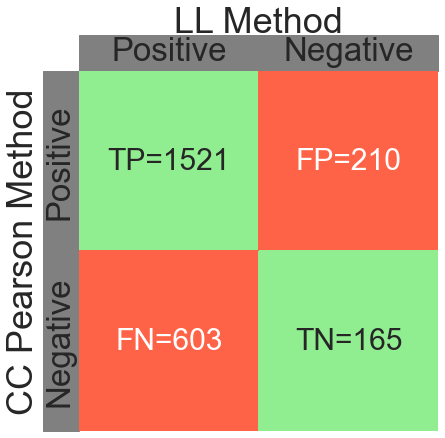

In [1252]:

cm = [[TP, FP], [TN, FN]] # TP, FP, FN, TN
sns.set(font_scale=3)
plt.figure(figsize=(7, 7))
ax = sns.heatmap(data=[[1, 0], [0, 1]], cmap=sns.color_palette(['tomato', 'lightgreen'], as_cmap=True),
                 annot=[[f"TP={cm[0][0]:.0f}", f"FP={cm[0][1]:.0f}"], [f"FN={cm[1][0]:.0f}", f"TN={cm[1][1]:.0f}"]],
                 fmt='', annot_kws={'fontsize': 30}, cbar=False, square=True)

ax.set_xlabel('LL Method')
ax.set_ylabel('CC Pearson Method')
ax.tick_params(length=0, labeltop=True, labelbottom=False)
ax.xaxis.set_label_position('top')
ax.set_xticklabels(['Positive', 'Negative'])
ax.set_yticklabels(['Positive', 'Negative'], rotation=90, va='center')
ax.add_patch(plt.Rectangle((0, 1), 1, 0.1, color='grey', clip_on=False, zorder=0, transform=ax.transAxes))
ax.add_patch(plt.Rectangle((0, 0), -0.1, 1, color='grey', clip_on=False, zorder=0, transform=ax.transAxes))
plt.tight_layout()
plt.show()

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


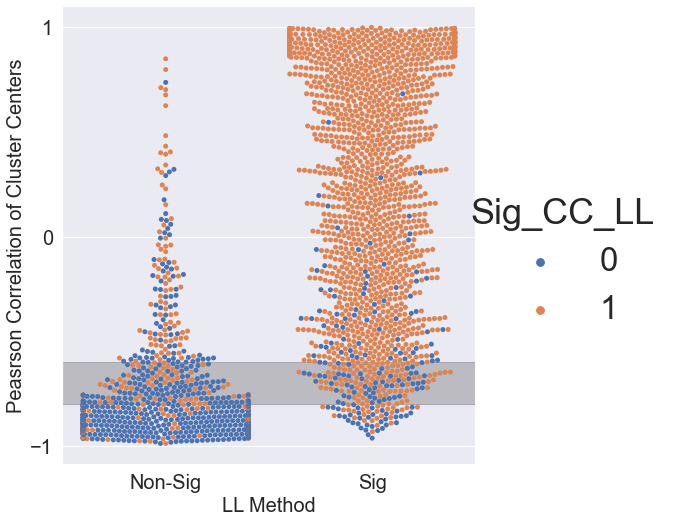

In [1253]:
sns.catplot(x='Sig_LL', y='CCp', hue='Sig_CC_LL', data= sig_con, kind='swarm', height = 8)
plt.xticks([0,1], ['Non-Sig', 'Sig'], fontsize=20)
plt.xlabel('LL Method', fontsize=20)
plt.yticks([-1,0,1],fontsize=20)
plt.ylabel('Peasrson Correlation of Cluster Centers', fontsize=20)
plt.axhspan(-0.8,-0.6, color=[0,0,0], alpha=0.2)
#plt.legend(['Non-Sig', 'Sig'], fontsize=20)

In [8]:
STOP

NameError: name 'STOP' is not defined

## sig trials

In [642]:
import significance_funcs as sigf

In [1342]:
if "LL_onset" not in con_trial:
    con_trial.insert(4, 'LL_onset', 0)

In [1343]:
sc = 0
rc = 3
dat = sig_con.loc[(sig_con.Stim == sc) & (sig_con.Chan == rc)]
if dat.Sig_CC_LL.values[0]:
    thr = 1.1*surr_thr.loc[surr_thr.Chan==rc,'CC_LL99'].values[0]
    M_GT = M_GT_all[sc, rc, :, :]
    if len(np.where(dat[['CC_LL1','CC_LL2']].values[0][:]<thr)[0][:]+1)>0:
        M_GT = np.delete(np.where(dat[['CC_LL1','CC_LL2']].values[0][:]<thr)[0][:]+1, 0)
    # M_GT[np.where(dat[['CC_LL1','CC_LL2']].values[0][:]<thr)[0][:]+1,:] = np.nan
    t_resp = dat.t_onset.values[0]

In [1344]:
con_trial = get_sig(sc, rc, con_trial, M_GT, t_resp, sig_mean, EEG_CR, p=95, exp=2,
                                         w_cluster=0.25)

In [1341]:
# con_trial.insert(5,'Sig_CC',-1)

In [683]:
con_trial_sig = con_trial[con_trial.d > -10]
con_trial_sig.loc[con_trial_sig.Sig_CC == 1, 'Sig_CC'] = 0
con_trial_sig.loc[con_trial_sig.Sig_CC == 2, 'Sig_CC'] = 1
con_trial_sig.insert(4, 'LL_sig', np.nan)
con_trial_sig.loc[con_trial_sig.Sig_CC == 1, 'LL_sig'] = con_trial_sig.loc[con_trial_sig.Sig_CC == 1, 'LL']
summ = con_trial_sig[(con_trial_sig.Sig_CC > -1)]  # only possible connections
summ = summ.groupby(['Stim', 'Chan', 'SleepState'], as_index=False)[['Sig_CC', 'LL_sig', 'd']].mean()

In [ ]:
M_DI = np.zeros((len(self.labels_all),5))

In [ ]:
for sc in range(M_t_resp.shape[0]):
    for rc in range(sc, M_t_resp.shape[0]):

In [1511]:
con_trial.to_csv(file_con,
                         index=False,
                         header=True)

In [1393]:
con_trial.Sig_CC = -1
for sc in tqdm(np.unique(con_trial.Stim), desc='Stimulation Channel'):
    sc = int(sc)
    resp_chans = np.unique(con_trial.loc[(con_trial.Artefact == 0) & (con_trial.Stim == sc), 'Chan']).astype(
        'int')
    for rc in resp_chans:
        dat = sig_con.loc[(sig_con.Stim == sc) & (sig_con.Chan == rc)]
        if dat.Sig_CC_LL.values[0]:
            thr = 1.1*surr_thr.loc[surr_thr.Chan==rc,'CC_LL99'].values[0]
            M_GT = M_GT_all[sc, rc, :, :]
            if len(np.where(dat[['CC_LL1','CC_LL2']].values[0][:]<thr)[0][:]+1)>0:
                M_GT = np.delete(M_GT,np.where(dat[['CC_LL1','CC_LL2']].values[0][:]<thr)[0][:]+1, 0)
            # M_GT[np.where(dat[['CC_LL1','CC_LL2']].values[0][:]<thr)[0][:]+1,:] = np.nan
            t_resp = dat.t_onset.values[0]
            con_trial = get_sig(sc, rc, con_trial, M_GT, t_resp, sig_mean, EEG_CR, p=95, exp=2,
                                         w_cluster=0.25)
        else:
            con_trial.loc[(con_trial.Chan == rc) & (con_trial.Stim == sc), 'Sig_CC'] =0

Stimulation Channel:   0%|          | 0/50 [00:00<?, ?it/s]

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\numpy\lib\nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [1339]:
def get_sig(sc, rc, con_trial, M_GT, t_resp, sig_mean, EEG_CR, p=95, exp=2, w_cluster=0.25, t_0=1):
    # for each trial get significance level based on surrogate (Pearson^2 * LL)
    dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
    EEG_trials = ff.lp_filter(EEG_CR[[[rc]], dat.Num.values.astype('int'), :], 45, Fs)
    LL_trials = LLf.get_LL_all(EEG_trials, Fs, w_cluster)
    # surr
    pear_surr_all = []
    f = 1
    for t_test in [0.3, 0.7, 1.8, 2.2, 2.6]:  # surrogates times, todo: in future blockwise
        s = (-1) ** f
        pear = np.zeros((len(EEG_trials[0]),))-1
        for n_c in range(len(M_GT)):
            pear = np.max([pear, sigf.get_pearson2mean(M_GT[n_c, :], s * EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                     Fs=500)],0)

        LL = LL_trials[0, :, int((t_test + w_cluster / 2) * Fs)]
        # pear_surr = np.arctanh(np.max([pear,pear2],0))*LL
        pear_surr = np.sign(pear) * abs(pear ** exp) * LL
        pear_surr_all = np.concatenate([pear_surr_all, pear_surr])
        f = f + 1
    # other trials
    real_trials = np.unique(
        con_trial.loc[(con_trial.Stim == sc) & (con_trial.Chan == rc), 'Num'].values.astype('int'))
    stim_trials = np.unique(
        con_trial.loc[(con_trial.Stim >= rc - 1) & (con_trial.Stim <= rc + 1), 'Num'].values.astype('int'))
    StimNum = np.random.choice(np.unique(con_trial.Num), size=400)
    StimNum = [i for i in StimNum if i not in stim_trials]
    StimNum = [i for i in StimNum if i not in stim_trials + 1]
    StimNum = [i for i in StimNum if i not in real_trials]

    StimNum = np.unique(StimNum).astype('int')
    EEG_surr = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)
    bad_StimNum = np.where(np.max(abs(EEG_surr[0]), 1) > 1000)
    if (len(bad_StimNum[0]) > 0):
        StimNum = np.delete(StimNum, bad_StimNum)
        EEG_surr = ff.lp_filter(EEG_CR[[[rc]], StimNum, :], 45, Fs)
    LL_surr = LLf.get_LL_all(EEG_surr, Fs, w_cluster)
    for t_test in [0.3, 0.7, 1.8, 2.2, 2.6]:  # surrogates times, todo: in future blockwise
        s = (-1) ** f

        pear = np.zeros((len(EEG_surr[0]),)) - 1
        for n_c in range(len(M_GT)):
            pear = np.max([pear, sigf.get_pearson2mean(M_GT[n_c, :], s * EEG_surr[0], tx=t_0 + t_resp, ty=t_test,
                                                       win=w_cluster,
                                                       Fs=500)], 0)


        LL = LL_surr[0, :, int((t_test + w_cluster / 2) * Fs)]
        # pear_surr = np.arctanh(np.max([pear,pear2],0))*LL
        pear_surr = np.sign(pear) * abs(pear ** exp) * LL
        pear_surr_all = np.concatenate([pear_surr_all, pear_surr])
        f = f + 1

    # real
    t_test = t_0 + t_resp

    pear = np.zeros((len(EEG_trials[0]),)) - 1
    for n_c in range(len(M_GT)):
        pear = np.max(
            [pear, sigf.get_pearson2mean(M_GT[n_c, :], s * EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                         Fs=500)], 0)

    LL = LL_trials[0, :, int((t_test + w_cluster / 2) * Fs)]
    pear = np.sign(pear) * abs(pear ** exp) * np.sqrt(LL)
    sig = (pear > np.nanpercentile(pear_surr_all, p)) * 1
    con_trial.loc[
        (con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1), 'Sig_CC'] = sig * sig_mean
    con_trial.loc[
        (con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1), 'LL_onset'] = LL
    return con_trial

## AUC 

In [ ]:
# stims = np.zeros((len(labels_all), 1))
# stims[:,0] = np.arange(len(labels_all))
# M_CCp_surr = np.zeros((len(labels_all), 2))
# M_CC_LL_surr = np.zeros((len(labels_all), 2))+2
# np.concatenate([stims,M_CCp_surr,M_CC_LL_surr],1)

In [1823]:
file_auc= path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/AUC_connection.csv'

In [1824]:
subj = 'EL011'
file_AUC = path_patient_analysis + '\\InputOutput/' + cond_folder + '/data/AUC_connection.csv'
AUC_all = pd.read_csv(file_AUC)

In [1827]:
AUC_all  = AUC_all.drop(columns='d')

In [1841]:
AUC_all

,Stim,Chan,AUC,SleepState
0,7,0,0.788961,NREM
1,7,0,0.807556,REM
2,7,0,0.745832,Wake
3,7,0,0.756862,All
4,7,1,0.804147,NREM
...,...,...,...,...
919,65,83,0.332046,All
920,65,84,1.185055,NREM
921,65,84,0.654153,REM
922,65,84,0.264691,Wake


In [1839]:
BM_all

,Stim,Chan,Sig,LL_sig,SleepState,d
350,7.0,0.0,0.985075,3.892072,All,11.46
351,7.0,1.0,1.000000,4.189981,All,14.28
352,7.0,2.0,0.990050,4.041431,All,17.34
353,7.0,3.0,0.916667,3.110685,All,20.55
354,7.0,4.0,0.921569,2.556134,All,23.83
...,...,...,...,...,...,...
6133,65.0,85.0,0.000000,NaN,REM,65.05
6134,65.0,85.0,0.000000,NaN,Wake,65.05
6135,65.0,86.0,0.000000,NaN,NREM,67.19
6136,65.0,86.0,0.000000,NaN,REM,67.19


In [1843]:
data_AUC_Prob = pd.merge(BM_all, AUC_all, on =['Stim', 'Chan', 'SleepState'])

In [1836]:
con_trial_sig = con_trial[(con_trial.Sig >-1)& (con_trial.d > -10)]

con_trial_sig.insert(4, 'LL_sig', np.nan)
con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL_sig'] = con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL']
summ = con_trial_sig[(con_trial_sig.Sig > -1)]  # only possible connections
summ_AUC = summ.groupby(['Stim', 'Chan', 'SleepState'], as_index=False)[['Sig', 'LL_sig', 'd']].mean()
#summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['Sig', 'LL_sig', 'd']].mean()
summ_all = summ_AUC[np.isin(summ_AUC.Stim, np.unique(AUC_all.Stim))]


# 
summ_AUC = summ.groupby(['Stim', 'Chan'], as_index=False)[['Sig', 'LL_sig', 'd']].mean()
summ_AUC.insert(4,'SleepState', 'All')
summ_sleep = summ_AUC[np.isin(summ_AUC.Stim, np.unique(AUC_all.Stim))]
BM_all = pd.concat([summ_sleep, summ_all])
data_AUC_Prob = pd.merge(BM_all, AUC_all, on =['Stim', 'Chan', 'SleepState'])

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [1846]:
data_AUC_Prob

,Stim,Chan,Sig,LL_sig,SleepState,d,AUC
0,7.0,0.0,0.985075,3.892072,All,11.46,0.756862
1,7.0,1.0,1.000000,4.189981,All,14.28,0.764230
2,7.0,2.0,0.990050,4.041431,All,17.34,0.729927
3,7.0,3.0,0.916667,3.110685,All,20.55,0.689310
4,7.0,4.0,0.921569,2.556134,All,23.83,0.769229
...,...,...,...,...,...,...,...
499,65.0,68.0,1.000000,8.378835,REM,7.00,0.603590
500,65.0,68.0,1.000000,8.799246,Wake,7.00,0.563201
501,65.0,69.0,0.863636,6.438117,NREM,10.50,0.701296
502,65.0,69.0,1.000000,4.886034,REM,10.50,0.609660


In [1862]:
stims = np.unique(data_AUC_Prob.Stim)

([<matplotlib.axis.YTick at 0x1beab597488>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

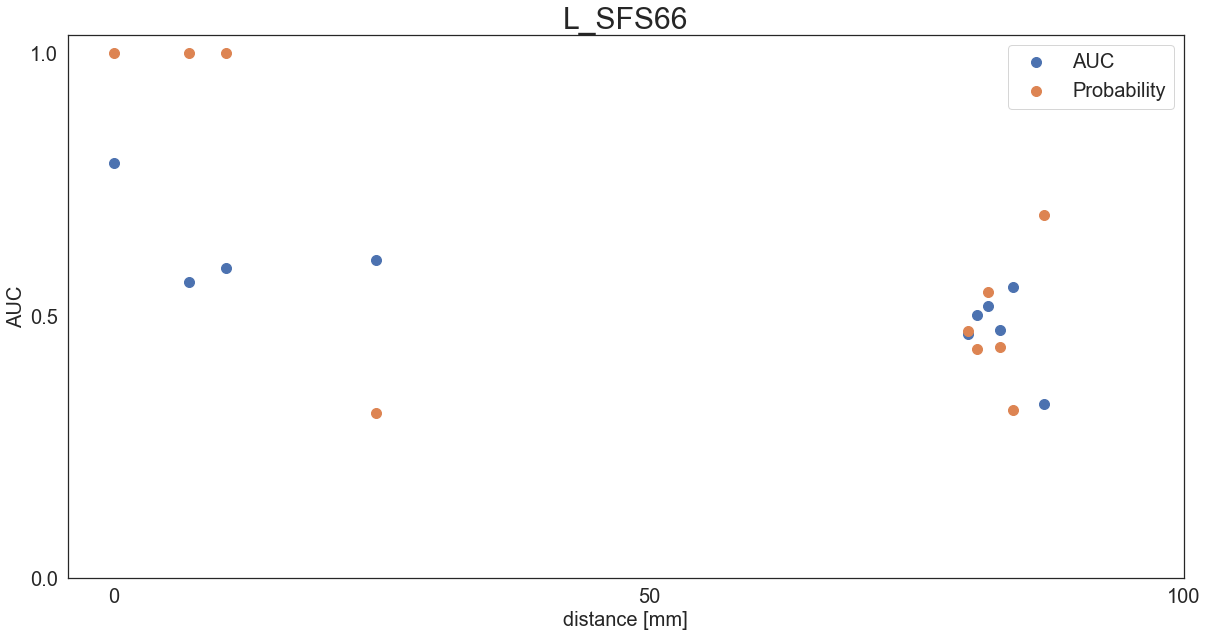

In [1866]:
plt.figure(figsize=(20,10))
sc = stims[3].astype('int')

data_plot = data_AUC_Prob[(data_AUC_Prob.Stim==sc)&(data_AUC_Prob.SleepState=='Wake')&(data_AUC_Prob.Sig>0)]
plt.title(labels_all[sc], fontsize=30)
plt.scatter(data_plot.d, data_plot.AUC, label ='AUC', s= 100)
plt.scatter(data_plot.d, data_plot.Sig, label ='Probability', s = 100)
plt.legend(fontsize=20)
# sns.scatterplot(x='d', y='AUC',data=, s= 100 )
# sns.scatterplot(x='d', y='Sig',data=data_AUC_Prob[(data_AUC_Prob.Stim==sc)&(data_AUC_Prob.SleepState=='Wake')&(data_AUC_Prob.Sig>0)], s= 100 )

plt.ylabel('AUC', fontsize=20)
plt.xlabel('distance [mm]', fontsize=20)
plt.xticks([0, 50, 100], fontsize=20)
plt.yticks([0, 0.5, 1], fontsize=20)

([<matplotlib.axis.YTick at 0x1be988e7b48>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

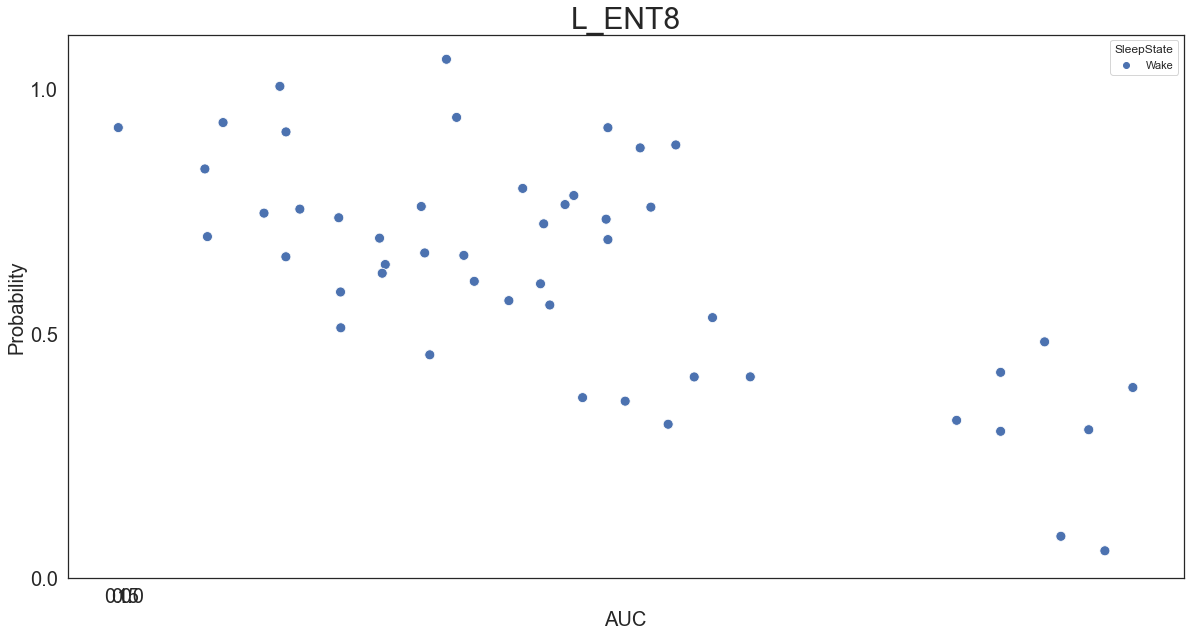

In [1847]:
plt.figure(figsize=(20,10))
sc = 7
plt.title(labels_all[sc], fontsize=30)
sns.scatterplot(x='d', y='AUC', hue='SleepState',data=data_AUC_Prob[(data_AUC_Prob.Stim==sc)&(data_AUC_Prob.SleepState=='Wake')&(data_AUC_Prob.Sig>0)], s= 100 )
plt.ylabel('Probability', fontsize=20)
plt.xlabel('AUC', fontsize=20)
plt.xticks([0, 0.5, 1], fontsize=20)
plt.yticks([0, 0.5, 1], fontsize=20)

([<matplotlib.axis.YTick at 0x1be9597d6c8>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

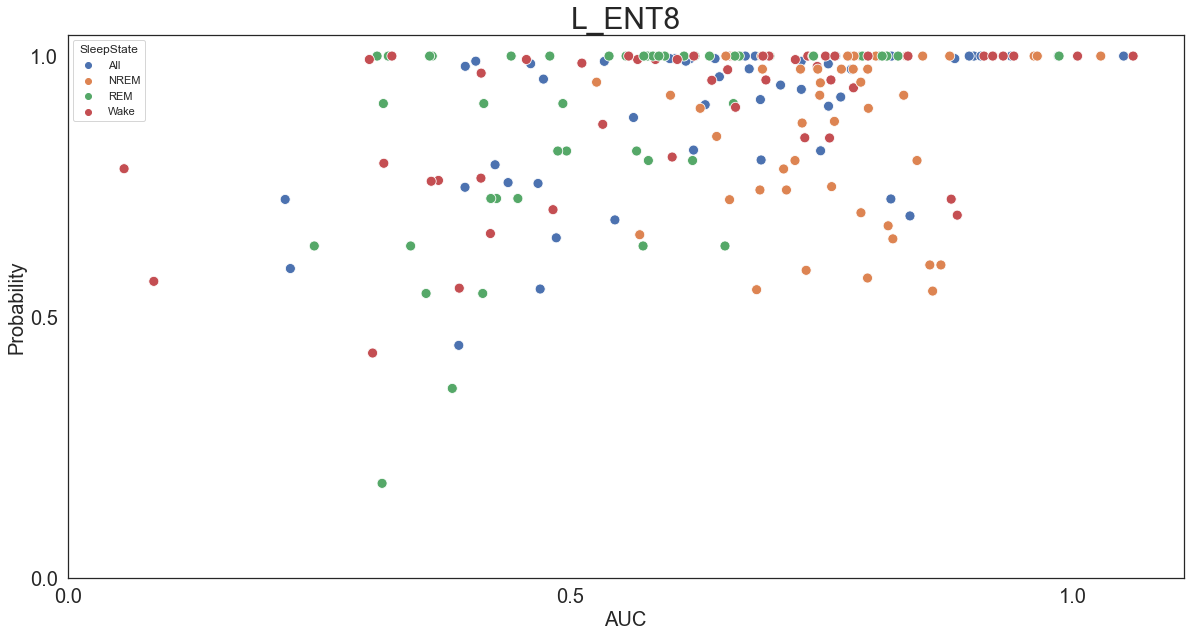

In [1845]:
plt.figure(figsize=(20,10))
sc = 7
plt.title(labels_all[sc], fontsize=30)
sns.scatterplot(x='AUC', y='Sig', hue='SleepState',data=data_AUC_Prob[(data_AUC_Prob.Stim==sc)&(data_AUC_Prob.Sig>0)], s= 100 )
plt.ylabel('Probability', fontsize=20)
plt.xlabel('AUC', fontsize=20)
plt.xticks([0, 0.5, 1], fontsize=20)
plt.yticks([0, 0.5, 1], fontsize=20)

In [1361]:
sig_labels = ['Non-Sig', 'Sig']

In [1505]:
dat = sig_con.loc[(sig_con.Stim == sc) & (sig_con.Chan == rc)]
dat

,Stim,Chan,Sig_LL,Sig_CC_LL,Sig_CC,t_onset,t_resp,CCp,CC_LL1,CC_LL2


In [1503]:
dat = sig_con.loc[(sig_con.Stim == sc) & (sig_con.Chan == rc)]
if dat.Sig_CC_LL.values[0]:
    thr = 1.1*surr_thr.loc[surr_thr.Chan==rc,'CC_LL99'].values[0]
    M_GT = M_GT_all[sc, rc, :, :]
    if len(np.where(dat[['CC_LL1','CC_LL2']].values[0][:]<thr)[0][:]+1)>0:
        M_GT = np.delete(M_GT,np.where(dat[['CC_LL1','CC_LL2']].values[0][:]<thr)[0][:]+1, 0)

    # M_GT[np.where(dat[['CC_LL1','CC_LL2']].values[0][:]<thr)[0][:]+1,:] = np.nan
    t_resp = dat.t_onset.values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

(-0.5, 1.0)

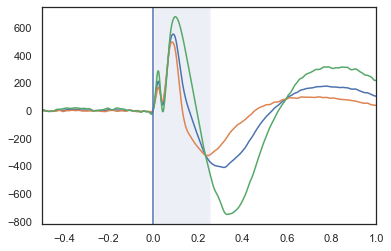

In [1453]:
for i in range(M_GT.shape[0]):
    plt.plot(x_ax, M_GT[i])
plt.axvline(0)
plt.axvspan(t_resp, t_resp+0.25, alpha=0.1)
plt.xlim([-0.5,1])

In [1957]:
bad_trials = np.zeros((3,1))
bad_trials[:,0] =[4419.,  7265., 10259.] 

In [1959]:
bad_trials =pd.DataFrame(bad_trials, columns=['Bad_trial'])

In [1961]:
bad_trials.insert(1,'Reason', 'TTL')

In [1963]:
bad_trials.to_csv(path_patient_analysis + '\\' + folder + '/data/badtrial.csv', header=True, index=False)

In [1980]:
con_trial.loc[np.isin(con_trial.Num, bad_trials.Bad_trial.values), 'Artefact'] =1

In [1974]:
np.where(np.isin(con_trial.Num, bad_trials.Bad_trial.values))

(array([234651, 234801, 234951, 235101, 235251, 235401, 235551, 235701,
        235851, 236001, 236151, 236301, 236451, 236601, 236751, 236901,
        237051, 237201, 237351, 237501, 237651, 237801, 237951, 238101,
        238251, 238401, 238551, 238701, 238851, 239001, 239151, 239301,
        239451, 239601, 239751, 239901, 240051, 240201, 240351, 240501,
        240651, 240801, 240951, 241101, 241251, 241401, 241551, 241701,
        241851, 242001, 242151, 242301, 242451, 242601, 388547, 388697,
        388847, 388997, 389147, 389297, 389447, 389597, 389747, 389897,
        390047, 390197, 390347, 390497, 390647, 390797, 390947, 391097,
        391247, 391397, 391547, 391697, 391847, 391997, 392147, 392297,
        392447, 392597, 392747, 392897, 393047, 393197, 393347, 393497,
        393647, 393797, 393947, 394097, 394247, 394397, 394547, 394697,
        394847, 394997, 395147, 395297, 395447, 395597, 395747, 395897,
        396047, 396197, 396347, 396497, 550541, 550691, 550841, 

In [1970]:
 bad_trials.Bad_trial.values

array([ 4419.,  7265., 10259.])

In [1981]:
con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact <1)& (con_trial.Sig ==0)]

,Chan,Stim,LL,P2P,LL_onset,Sig,Hour,SleepState,Block,Sleep,Num,Num_block,Date,Artefact,d,Artefact


In [1998]:
dat

,Chan,Stim,LL,P2P,LL_onset,Sig,Hour,SleepState,Block,Sleep,Num,Num_block,Date,Artefact,d,Artefact


In [2008]:
channels = np.array([[49,38],[49,44],[19,16],[14,19],[14,0],[16,19],[3, 0],[16,14],[0,3],[65,85],[85,65],[38,49],[18,65],[18,85],[18,0],[29,9],[29,1],[19,85],[19,65]])

channels = np.array([[49,38],[49,44],[19,16],[14,19],[14,0],[16,19],[3, 0],[16,14],[0,3],[65,85],[85,65],[38,49],[18,65],[18,85],[18,0],[29,9],[29,1],[19,85],[19,65]])
for n_c in range(len(channels)):
    sc = channels[n_c,0]
    rc = channels[n_c,1]
    dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
    if len(dat)>0:
        dat_c = sig_con.loc[(sig_con.Stim == sc) & (sig_con.Chan == rc)]
        t_resp = dat_c.t_onset.values[0]
        fig = plt.figure(figsize=(8, 12))
        fig.patch.set_facecolor('xkcd:white')
        plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc]+', Prob: '+str(np.round(dat.Sig.mean()*100,1))+'%', fontsize=30)
        stimNum_all = dat.Num.values.astype('int')
        ylim = 1.6*np.percentile(abs(EEG_CR[rc, stimNum_all,500:750]), 99)
        print(ylim)
        gs = fig.add_gridspec(2,1)  # GridSpec(4,1, height_ratios=[1,2,1,2])
        # ylim = 1000
        for sig,ix in zip([0,1],[0,1]):
            dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact <1)& (con_trial.Sig ==sig)]
            stimNum_all = dat.Num.values.astype('int')
            fig.add_subplot(gs[ix,0])
            plt.title(sig_labels[ix], fontsize=20)
            if len(stimNum_all)>0:
                mn = ff.lp_filter(np.nanmean(EEG_CR[rc, stimNum_all, :], 0),45,Fs)
                for i in range(np.min([50, len(stimNum_all)])):
                    # i = np.random.choice(stimNum_all,(1))
                    plt.plot(x_ax, ff.lp_filter(EEG_CR[rc,stimNum_all[i],:],45,Fs), color=color_elab[0], alpha=0.9)
                plt.plot(x_ax, mn, color= [0,0,0], linewidth= 5, label='n: '+str(len(stimNum_all)), alpha=0.5)

            plt.xlim([-0.5,1])
            plt.axvline(0,color= [1,0,0], linewidth=4)
            plt.ylim([-ylim,ylim])
            plt.xticks([])
            plt.legend(fontsize=20)
            plt.axvspan(t_resp, t_resp+0.25, alpha=0.1)
            plt.yticks([-500,0,500],fontsize=20)
            plt.ylabel('uV',fontsize=22)
        plt.xticks([-0.5,0,0.5, 1], fontsize=20)
        plt.xlabel('time [s]', fontsize=22)
        plt.tight_layout()
        plt.savefig(path_patient_analysis+'\\BrainMapping\\CR\methods\\trial_sig_example\\'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
        plt.close()

858.3648341225667
916.2622653481542
359.5939694805819
400.81443396553675


No handles with labels found to put in legend.


287.47376651785544


No handles with labels found to put in legend.


443.74197426005367


No handles with labels found to put in legend.


961.7798337292294
337.7996531589172


No handles with labels found to put in legend.


266.7168363714681


No handles with labels found to put in legend.


292.6444866493384
328.54577684792315
552.6045213762321
436.41248249180745
605.4069268617008
768.8584916365746
485.2644225696273
600.9571810939723
826.8072223066313


In [ ]:
channels = np.array([[49,38],[49,44],[19,16],[16,19],[3, 0],[16,14],[0,3],[65,85],[85,65],[38,49],[18,65],[18,85],[18,0],[29,9],[29,1],[19,65]])
channels = np.array([[49,47]])
for n_c in range(len(channels)):
    sc = channels[n_c,0]
    rc = channels[n_c,1]

    t_resp = cc[sc, rc, 0]
    w_cluster = 0.25
    dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
    stimNum_all = dat.Num.values.astype('int')
    fig = plt.figure(figsize=(30, len(methods)*5))
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc], fontsize=30)

    gs = fig.add_gridspec(len(methods), 3, width_ratios=[1, 2, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    M_GT = np.zeros((2,2000))
    if len(stimNum_all) > 0:
        # get overall mean and two clusters
        EEG_trial = ff.lp_filter(EEG_CR[rc, stimNum_all, :], 45, Fs)
        # EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)
        LL_trials = LLf.get_LL_all(np.expand_dims(EEG_trial,0), Fs, w_cluster)
        ylim = np.max([np.min([800,1.1*np.max(abs(EEG_trial[:,500:1000]))]),200])
        for m in range(len(methods)):
            method = methods[m]
            cc, y = dba_cluster(EEG_trial[:, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)], n_cluster, method)
            M_GT[0,int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)] =cc[0]
            M_GT[1,int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)] =cc[1]
            pear_surr_all = []
            pear_surr = np.zeros((len(EEG_trial)))-1
            for t_test in [0, 0.1, 0.2, 0.5, 1.5, 2, 2.5]:
                for i in range(len(M_GT)):
                    pear_surr = np.max([pear_surr, sig_func.get_pearson2mean(M_GT[i, :], EEG_trial, tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                                 Fs=500)],0)
                LL = LL_trials[0, :, int((t_test + w_cluster / 2) * Fs)]
                pear_surr_LL = np.sign(pear_surr) * abs(pear_surr ** 2) * LL  #*np.sqrt(LL)
                pear_surr_all = np.concatenate([pear_surr_all, pear_surr_LL])
            # real
            t_test = t_0 + t_resp
            pear = np.zeros((len(EEG_trial)))-1
            for i in range(len(M_GT)):
                    pear = np.max([pear, sig_func.get_pearson2mean(M_GT[i, :], EEG_trial, tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                                 Fs=500)],0)
            LL = np.max(LL_trials[0, :, int((t_test + w_cluster / 2) * Fs):int((t_test + w_cluster) * Fs)],1)
            # pear = np.arctanh(np.max([pear,pear2],0))*LL#np.sign(np.max([pear,pear2],0))*abs(np.max([pear,pear2],0)**exp)*LL
            pear_test = np.sign(pear) * abs(pear ** 2) * LL  #*np.sqrt(LL), np.arctanh(pear)*LL # 
            sig_vals = (pear_test >= np.nanpercentile(pear_surr_all, 95)) * 1

            fig.add_subplot(gs[m, 0])
            # plt.title('Surrogate Testing', fontsize=20)
            plt.hist(pear_surr_all, label='surr', color=[0, 0, 0], alpha=0.3)
            plt.axvline(np.nanpercentile(pear_surr_all, 95), color=[1, 0, 0], label='95th')
            plt.hist(pear_test, label='trials', color=color_elab[0], alpha=0.8)
            #plt.hist(pear[sig==0],color=color_elab[0], alpha= 0.8)

            # plt.hist(pear[sig_vals == 1], color=color_elab[2], alpha=0.8)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            if m ==1: plt.xlabel('Pearson Correlation  *  LL', fontsize=20)
            plt.ylabel(method +' - clustering', fontsize=20)
            plt.legend(fontsize=15)
            for n_sig in range(2):
                fig.add_subplot(gs[m, n_sig+1])
                ix_sig = np.where([sig_vals == n_sig])[1] * 1
                if len(ix_sig) > 0:
                    mn = np.nanmean(EEG_trial[ix_sig, :], 0)
                    for i in range(1, np.min([10, len(ix_sig)])):
                        plt.plot(x_ax, EEG_trial[ix_sig[i]], color=color_elab[0], alpha=0.9)
                    plt.plot(x_ax, mn, color= [0,0,0], linewidth= 5, label='n: '+str(np.sum(sig_vals==n_sig)))
                    f = 100*m+1
                    plt.plot(x_ax, M_GT[0, :]*f, color= [1,0,0], linewidth= 2, label='CC1')
                    plt.plot(x_ax, M_GT[1, :]*f, color= [0.5,0.2,0], linewidth= 2, label='CC2')
                    #plt.plot(x_ax, ff.lp_filter(np.nanmean(EEG_trials[0,ix_sig,:],0),45,Fs), color=[0,0,0] )
                    plt.axvline(0, color=[1,0,0])
                    plt.axvline(t_resp,color=[0,0,0])
                    plt.legend()
                    plt.xlim([-0.5,1.5])
                    if m ==1: plt.xlabel('time [s]', fontsize=20)

                    if m ==0: plt.title(sig_label[n_sig]+ ' Trials', fontsize=20)
                    plt.ylim([-ylim, ylim])
                    plt.axvline(t_resp,color=[0,0,0])


    plt.savefig('Y:\\eLab\\EvM\\Projects\\EL_experiment\\Methods\\BrainMapping\\Significant_Connection\\Cluster_algorithm\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_surrTest.jpg')
    plt.close()

## Cluster trials into 2-3 groups

In [ ]:
Fs_rs = 100
num_rs = int(2000 / Fs * Fs_rs)
n_cluster = 2
t_0 = 1
t_resp = 0
w_cluster = 1
method = 'euclidean'
x_ax_C = np.linspace(0,1,Fs_rs)
x_ax_rs = np.linspace(-1,3,4*Fs_rs)
methods = ['dtw', 'euclidean', 'shape']

In [ ]:
from tslearn.clustering import TimeSeriesKMeans, KShape
import Cluster_func as Cf

In [ ]:
def dba_cluster(X, n=2, method = 'euclidean'):
    X = np.expand_dims(X,-1)
    if method == 'shape':
        ks = KShape(n_clusters=n, n_init=1, random_state=0).fit(X)
    else:
        ks  = TimeSeriesKMeans(n_clusters=n, metric=method, max_iter=10, max_iter_barycenter=10, random_state=0).fit(X)
    cc      = ks.cluster_centers_
    y       = ks.predict(X)
    return cc[:, :, 0], y

In [ ]:
sc = 3
rc = 0

dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
stimNum_all = dat.Num.values.astype('int')

if len(stimNum_all) > 0:
    # get overall mean and two clusters
    EEG_trial = ff.lp_filter(EEG_CR[rc, stimNum_all, :], 45, Fs)
    EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)

In [ ]:
colors_cluster = np.zeros((2,3))
colors_cluster[0] =color_elab[0]
colors_cluster[1] =color_elab[2]

In [ ]:
channels = np.array([[3, 0],[16,14],[0,3],[65,85],[85,65],[38,49],[18,65],[18,85],[18,0],[29,9],[29,1],[19,65]])
for n_c in range(len(channels)):
    sc = channels[n_c,0]
    rc = channels[n_c,1]
    dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
    stimNum_all = dat.Num.values.astype('int')

    if len(stimNum_all) > 0:
        # get overall mean and two clusters
        EEG_trial = ff.lp_filter(EEG_CR[rc, stimNum_all, :], 45, Fs)
        EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)
        
        ### figure
    fig = plt.figure(figsize=(25, 15))
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc], fontsize=30)
    k = 3
    gs = fig.add_gridspec(len(methods), 2, width_ratios=[1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    ylim = 200
    for m in range(len(methods)):
        method = methods[m]
        cc, y = dba_cluster(
            EEG_trial[:, int((t_0 + t_resp) * Fs_rs):int((t_0 + t_resp + w_cluster) * Fs_rs)], n_cluster, method)
        ## hypnogram
        fig.add_subplot(gs[m, 0])
        if m ==0: plt.title('Cluster Centroids', fontsize = 20)
        for i in range(len(cc)):
            plt.plot(x_ax_C,cc[i], linewidth=4, color= colors_cluster[i])

        if m ==len(methods)-1: 
            plt.xticks([0,0.5, 1], fontsize=15)
            plt.xlabel('times [s]', fontsize = 20)
        else:
            plt.xticks([])
        plt.ylabel(method, fontsize=20)

        plt.axvline(0, linewidth=3, color=[0,0,0])
        ## hypnogram
        if m ==0: 
            ax_m = fig.add_subplot(gs[m, 1])
            plt.title('Mean of trials within one cluster', fontsize = 20)
        else:
            fig.add_subplot(gs[m, 1], sharey = ax_m)
        for i in range(len(cc)):
            plt.plot(x_ax_rs,np.nanmean(EEG_trial[y == i, :], 0), linewidth=4, label = 'Cluster'+str(i+1)+', n: '+str(np.sum(y==i)), color= colors_cluster[i])
            ylim = np.max([ylim, np.max(abs(np.nanmean(EEG_trial[y == i, :], 0)))])
        plt.plot(x_ax_rs,np.nanmean(EEG_trial, 0), color=[0,0,0], linewidth=4, alpha=0.3, label = 'Mean')
        plt.legend(loc = 'lower left', fontsize=15)
        plt.axvspan(0,1,alpha=0.1)
        plt.xlim([-0.5,1.5])
        plt.axvline(0, linewidth=3, color=[0,0,0])
        if m ==len(methods)-1: 
            plt.xticks([-0.5,0,0.5, 1,1.5], fontsize=15)
            plt.xlabel('times [s]', fontsize = 20)
        else:
            plt.xticks([])
    plt.savefig('Y:\\eLab\\EvM\\Projects\\EL_experiment\\Methods\\BrainMapping\\Significant_Connection\\Cluster_algorithm\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
    plt.close()

In [ ]:
### figure
fig = plt.figure(figsize=(25, 15))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc], fontsize=30)
k = 3
gs = fig.add_gridspec(len(methods), 2, width_ratios=[1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
ylim = 200
for m in range(len(methods)):
    method = methods[m]
    cc, y = dba_cluster(
        EEG_trial[:, int((t_0 + t_resp) * Fs_rs):int((t_0 + t_resp + w_cluster) * Fs_rs)], n_cluster, method)
    ## hypnogram
    fig.add_subplot(gs[m, 0])
    if m ==0: plt.title('Cluster Centroids', fontsize = 20)
    for i in range(len(cc)):
        plt.plot(x_ax_C,cc[i], linewidth=4, color= colors_cluster[i])

    if m ==len(methods)-1: 
        plt.xticks([0,0.5, 1], fontsize=15)
        plt.xlabel('times [s]', fontsize = 20)
    else:
        plt.xticks([])
    plt.ylabel(method, fontsize=20)
        
    plt.axvline(0, linewidth=3, color=[0,0,0])
    ## hypnogram
    if m ==0: 
        ax_m = fig.add_subplot(gs[m, 1])
        plt.title('Mean of trials within one cluster', fontsize = 20)
    else:
        fig.add_subplot(gs[m, 1], sharey = ax_m)
    for i in range(len(cc)):
        plt.plot(x_ax_rs,np.nanmean(EEG_trial[y == i, :], 0), linewidth=4, label = 'Cluster'+str(i+1)+', n: '+str(len(y==i)), color= colors_cluster[i])
        ylim = np.max([ylim, np.max(abs(np.nanmean(EEG_trial[y == i, :], 0)))])
    plt.plot(x_ax_rs,np.nanmean(EEG_trial, 0), color=[0,0,0], linewidth=4, alpha=0.3, label = 'Mean')
    plt.legend(loc = 'lower left', fontsize=15)
    plt.axvspan(0,1,alpha=0.1)
    plt.xlim([-0.5,1.5])
    plt.axvline(0, linewidth=3, color=[0,0,0])
    if m ==len(methods)-1: 
        plt.xticks([-0.5,0,0.5, 1,1.5], fontsize=15)
        plt.xlabel('times [s]', fontsize = 20)
    else:
        plt.xticks([])
plt.savefig('Y:\\eLab\\EvM\\Projects\\EL_experiment\\Methods\\BrainMapping\\Significant_Connection\\Cluster_algorithm\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
plt.close()

### trial significance test with 2 methods

In [1516]:
M_t_resp[0,3]


array([ 1.        ,  0.        ,  0.        , -0.35521658,  1.        ])

In [ ]:
m = 1

In [ ]:
EEG_trial.shape

In [ ]:
EEG_trial = ff.lp_filter(EEG_CR[rc, stimNum_all, :], 45, Fs)
# EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)
LL_trials = LLf.get_LL_all(np.expand_dims(EEG_trial,0), Fs, w_cluster)

In [ ]:

method = methods[m]
cc, y = dba_cluster(
    EEG_trial[:, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)], n_cluster, method)
M_GT[0,int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)] =cc[0]
M_GT[1,int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)] =cc[1]
pear_surr_all = []
pear = np.zeros((len(EEG_trial)))-1
for t_test in [0, 0.1, 0.2, 0.5, 1.5, 2, 2.5]:
    for i in range(len(M_GT)):
        pear = np.max([pear, sig_func.get_pearson2mean(M_GT[i, :], EEG_trial, tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                     Fs=500)],0)
    LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
    pear_surr = np.sign(pear) * abs(pear ** 2) * LL  #*np.sqrt(LL)
    pear_surr_all = np.concatenate([pear_surr_all, pear_surr])
        

In [ ]:
methods = ['euclidean', 'shape']

In [ ]:
sig_label = ['Nonsig', 'Sig']

In [ ]:
pear_surr_all

In [ ]:
sig_vals

In [ ]:
pear

In [ ]:
pear_surr

In [ ]:
np.max([pear_surr, sig_func.get_pearson2mean(M_GT[i, :], EEG_trial, tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                             Fs=500)],0)

In [ ]:
method = methods[m]
cc, y = dba_cluster(EEG_trial[:, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)], n_cluster, method)
M_GT[0,int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)] =cc[0]
M_GT[1,int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)] =cc[1]
pear_surr_all = []
pear_surr = np.zeros((len(EEG_trial)))-1

In [ ]:
pear_surr = sig_func.get_pearson2mean(M_GT[0, :], EEG_trial, tx=t_0 + t_resp, ty=0, win=w_cluster,
                                             Fs=500)

In [ ]:
pear_surr2 = sig_func.get_pearson2mean(M_GT[1, :], EEG_trial, tx=t_0 + t_resp, ty=0, win=w_cluster,
                                             Fs=500)

In [ ]:
pear_trial = sig_func.get_pearson2mean(M_GT[1, :], EEG_trial, tx=t_0 + t_resp, ty=t_0 + t_resp, win=w_cluster,
                                             Fs=500)
pear_trial2 = sig_func.get_pearson2mean(M_GT[0, :], EEG_trial, tx=t_0 + t_resp, ty=t_0 + t_resp, win=w_cluster,
                                             Fs=500)

In [ ]:

plt.hist(np.max([pear_surr,pear_surr2],0))
plt.hist(np.max([pear_trial,pear_trial2],0))

In [ ]:
t_test

In [ ]:
plt.plot(LL_trials[0,0,:])
plt.axvline(int((t_test + w_cluster / 2) * Fs))

In [ ]:
EEG_trial

In [ ]:
channels = np.array([[49,38],[49,44],[19,16],[16,19],[3, 0],[16,14],[0,3],[65,85],[85,65],[38,49],[18,65],[18,85],[18,0],[29,9],[29,1],[19,65]])
channels = np.array([[49,47]])
for n_c in range(len(channels)):
    sc = channels[n_c,0]
    rc = channels[n_c,1]

    t_resp = M_t_resp[sc, rc, 0]
    w_cluster = 0.25
    dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact == 0)]
    stimNum_all = dat.Num.values.astype('int')
    fig = plt.figure(figsize=(30, len(methods)*5))
    fig.patch.set_facecolor('xkcd:white')
    plt.suptitle(labels_all[sc] + ' -- ' + labels_all[rc], fontsize=30)

    gs = fig.add_gridspec(len(methods), 3, width_ratios=[1, 2, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
    M_GT = np.zeros((2,2000))
    if len(stimNum_all) > 0:
        # get overall mean and two clusters
        EEG_trial = ff.lp_filter(EEG_CR[rc, stimNum_all, :], 45, Fs)
        # EEG_trial = signal.resample(EEG_trial, int(num_rs), axis=1)
        LL_trials = LLf.get_LL_all(np.expand_dims(EEG_trial,0), Fs, w_cluster)
        ylim = np.max([np.min([800,1.1*np.max(abs(EEG_trial[:,500:1000]))]),200])
        for m in range(len(methods)):
            method = methods[m]
            cc, y = dba_cluster(EEG_trial[:, int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)], n_cluster, method)
            M_GT[0,int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)] =cc[0]
            M_GT[1,int((t_0 + t_resp) * Fs):int((t_0 + t_resp + w_cluster) * Fs)] =cc[1]
            pear_surr_all = []
            pear_surr = np.zeros((len(EEG_trial)))-1
            for t_test in [0, 0.1, 0.2, 0.5, 1.5, 2, 2.5]:
                for i in range(len(M_GT)):
                    pear_surr = np.max([pear_surr, sig_func.get_pearson2mean(M_GT[i, :], EEG_trial, tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                                 Fs=500)],0)
                LL = LL_trials[0, :, int((t_test + w_cluster / 2) * Fs)]
                pear_surr_LL = np.sign(pear_surr) * abs(pear_surr ** 2) * LL  #*np.sqrt(LL)
                pear_surr_all = np.concatenate([pear_surr_all, pear_surr_LL])
            # real
            t_test = t_0 + t_resp
            pear = np.zeros((len(EEG_trial)))-1
            for i in range(len(M_GT)):
                    pear = np.max([pear, sig_func.get_pearson2mean(M_GT[i, :], EEG_trial, tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                                 Fs=500)],0)
            LL = np.max(LL_trials[0, :, int((t_test + w_cluster / 2) * Fs):int((t_test + w_cluster) * Fs)],1)
            # pear = np.arctanh(np.max([pear,pear2],0))*LL#np.sign(np.max([pear,pear2],0))*abs(np.max([pear,pear2],0)**exp)*LL
            pear_test = np.sign(pear) * abs(pear ** 2) * LL  #*np.sqrt(LL), np.arctanh(pear)*LL # 
            sig_vals = (pear_test >= np.nanpercentile(pear_surr_all, 95)) * 1

            fig.add_subplot(gs[m, 0])
            # plt.title('Surrogate Testing', fontsize=20)
            plt.hist(pear_surr_all, label='surr', color=[0, 0, 0], alpha=0.3)
            plt.axvline(np.nanpercentile(pear_surr_all, 95), color=[1, 0, 0], label='95th')
            plt.hist(pear_test, label='trials', color=color_elab[0], alpha=0.8)
            #plt.hist(pear[sig==0],color=color_elab[0], alpha= 0.8)

            # plt.hist(pear[sig_vals == 1], color=color_elab[2], alpha=0.8)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
            if m ==1: plt.xlabel('Pearson Correlation  *  LL', fontsize=20)
            plt.ylabel(method +' - clustering', fontsize=20)
            plt.legend(fontsize=15)
            for n_sig in range(2):
                fig.add_subplot(gs[m, n_sig+1])
                ix_sig = np.where([sig_vals == n_sig])[1] * 1
                if len(ix_sig) > 0:
                    mn = np.nanmean(EEG_trial[ix_sig, :], 0)
                    for i in range(1, np.min([10, len(ix_sig)])):
                        plt.plot(x_ax, EEG_trial[ix_sig[i]], color=color_elab[0], alpha=0.9)
                    plt.plot(x_ax, mn, color= [0,0,0], linewidth= 5, label='n: '+str(np.sum(sig_vals==n_sig)))
                    f = 100*m+1
                    plt.plot(x_ax, M_GT[0, :]*f, color= [1,0,0], linewidth= 2, label='CC1')
                    plt.plot(x_ax, M_GT[1, :]*f, color= [0.5,0.2,0], linewidth= 2, label='CC2')
                    #plt.plot(x_ax, ff.lp_filter(np.nanmean(EEG_trials[0,ix_sig,:],0),45,Fs), color=[0,0,0] )
                    plt.axvline(0, color=[1,0,0])
                    plt.axvline(t_resp,color=[0,0,0])
                    plt.legend()
                    plt.xlim([-0.5,1.5])
                    if m ==1: plt.xlabel('time [s]', fontsize=20)

                    if m ==0: plt.title(sig_label[n_sig]+ ' Trials', fontsize=20)
                    plt.ylim([-ylim, ylim])
                    plt.axvline(t_resp,color=[0,0,0])


    plt.savefig('Y:\\eLab\\EvM\\Projects\\EL_experiment\\Methods\\BrainMapping\\Significant_Connection\\Cluster_algorithm\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_surrTest.jpg')
    plt.close()

In [ ]:
##againt surrogate
t_resp = M_t_resp[sc, rc, 0]
# 1. get cluster centers
dat = con_trial[(con_trial.Stim == sc) & (con_trial.Chan == rc) & (con_trial.Artefact < 1)]
EEG_trials = ff.lp_filter(EEG_CR[[[rc]], dat.Num.values.astype('int'), :], 45, Fs)
LL_trials = LLf.get_LL_all(EEG_trials, Fs, w_cluster)


# surr
exp = 2
pear_surr_all = []
for t_test in [0, 0.1, 0.2, 0.5, 1.5, 2, 2.5]:
    pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                     Fs=500)  # Pearson# Pearson
    pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                      Fs=500)  # Pearson# Pearson
    LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
    #pear_surr = np.arctanh(np.max([pear,pear2],0))*LL
    pear_surr = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * LL  #*np.sqrt(LL)
    pear_surr_all = np.concatenate([pear_surr_all, pear_surr])

# real
t_test = t_0 + t_resp
pear = sig_func.get_pearson2mean(M_GT[1, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                 Fs=500)  # Pearson# Pearson
pear2 = sig_func.get_pearson2mean(M_GT[2, :], EEG_trials[0], tx=t_0 + t_resp, ty=t_test, win=w_cluster,
                                  Fs=500)  # Pearson# Pearson
LL = LL_trials[0, :, int(t_test + w_cluster / 2) * Fs]
# pear = np.arctanh(np.max([pear,pear2],0))*LL#np.sign(np.max([pear,pear2],0))*abs(np.max([pear,pear2],0)**exp)*LL
pear = np.sign(np.max([pear, pear2], 0)) * abs(np.max([pear, pear2], 0) ** exp) * LL  #*np.sqrt(LL)
sig = (pear > np.nanpercentile(pear_surr_all, 95)) * 1

plt.figure(figsize=(20, 20))
plt.title('Surrogate Testing', fontsize=40)
plt.hist(pear_surr_all, label='surr', color=[0, 0, 0], alpha=0.3)
plt.axvline(np.nanpercentile(pear_surr_all, 95), color=[1, 0, 0], label='95th')
plt.hist(pear, label='trials', color=color_elab[0], alpha=0.6)
#plt.hist(pear[sig==0],color=color_elab[0], alpha= 0.8)

plt.hist(pear[sig == 1], color=color_elab[0], alpha=0.8)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Pearson Correlation  *  LL', fontsize=35)
plt.legend(fontsize=40)
s, t_p = scipy.stats.ttest_ind(pear, pear_surr_all)
plt.tight_layout()
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\hist_surr\\con_'+str(sc)+'_'+str(rc)+'.jpg')
# plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\sig_trials\\hist_surr\\con_'+str(sc)+'_'+str(rc)+'.svg')

In [ ]:
def search_sequence_numpy(arr, seq):
    """ Find sequence in an array using NumPy only.

    Parameters
    ----------
    arr    : input 1D array
    seq    : input 1D array

    Output
    ------
    Output : 1D Array of indices in the input array that satisfy the
    matching of input sequence in the input array.
    In case of no match, an empty list is returned.
    """

    # Store sizes of input array and sequence
    Na, Nseq = arr.size, seq.size

    # Range of sequence
    r_seq = np.arange(Nseq)

    # Create a 2D array of sliding indices across the entire length of input array.
    # Match up with the input sequence & get the matching starting indices.
    M = (arr[np.arange(Na - Nseq + 1)[:, None] + r_seq] == seq).all(1)

    # Get the range of those indices as final output
    if M.any() > 0:
        return np.where(np.convolve(M, np.ones((Nseq), dtype=int)) > 0)[0]
    else:
        return []  # No match found

In [ ]:
stop

## load sleep data

In [ ]:
day = np.unique(con_trial.Date)
t0 = np.min(con_trial.loc[(con_trial.Date == day[0]), 'Hour']).astype('int')
t1 = np.max(con_trial.loc[(con_trial.Date == day[-1]), 'Hour']).astype('int')
total_hour = (len(day) - 1) * 24 - (t0 - t1) + 1

if os.path.isfile(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv'):
    time_overview = pd.read_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv')
else:
    time_overview = np.zeros((total_hour, 5))
    b0 = np.min(con_trial.Block)
    time_overview[:, :] = np.nan
    time_overview[:, 0] = np.arange(total_hour)
    i = 0
    h0 = np.bincount(con_trial.loc[con_trial.Block == b0, 'Hour']).argmax()
    for b in np.unique(con_trial.Block):
        date = np.bincount(con_trial.loc[con_trial.Block == b, 'Date']).argmax()
        d = np.where(day == date)[0]
        i = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax() + d * 24 - h0
        time_overview[i, 1] = d
        time_overview[i, 2] = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
        time_overview[i, 3] = b
        time_overview[i, 4] = b
    time_overview = pd.DataFrame(time_overview[:, :4], columns=['ix', 'Day', 'Hour', 'Block'])
    time_overview.insert(3, 'Hour_label', 0)
    for b in np.unique(time_overview.Block):
        if b > 0:
            time_overview.loc[time_overview.Block == b, 'Hour_label'] = str(
                int(time_overview.loc[time_overview.Block == b, 'Hour'])).zfill(2) + ':00'

    time_overview.to_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv', index=False, header=True)

# load hypnogram
file_hypno = path_patient_analysis + '/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
#stimlist_hypno.loc[(stimlist_hypno.ix_chron>30)&(stimlist_hypno.ix_chron<45), 'sleep'] = 0
for d in range(len(np.unique(stimlist_hypno.date))):
    stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d], 'ix_chron'] = stimlist_hypno.loc[
                                                                                                   stimlist_hypno.date ==
                                                                                                   np.unique(
                                                                                                       stimlist_hypno.date)[
                                                                                                       d], 'ix_h'] + d * 24
time_overview.insert(5, 'Hour_chron', time_overview.Hour + time_overview.Day * 24)
stimlist_hypno = stimlist_hypno[stimlist_hypno.stim_block > 0]
for p in np.unique(stimlist_hypno.Prot):
    stimlist_hypno.loc[stimlist_hypno.Prot == p, 'StimNum'] = stimlist_hypno.loc[
                                                                  stimlist_hypno.Prot == p, 'StimNum'] - np.min(
        stimlist_hypno.loc[stimlist_hypno.Prot == p, 'StimNum'])

### Blockwise

In [ ]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
WM_chans = np.where(labels_region == 'WM')[0]
bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')
stim_chans = np.arange(len(labels_all))
stim_chans = np.delete(stim_chans, bad_all, 0)

In [ ]:
con_trial = con_trial.loc[~(np.isin(con_trial.Chan, bad_chans)) & ~(np.isin(con_trial.Stim, bad_chans))]

In [ ]:
# BM plot
labels_region_L = lbls.Hemisphere.values + '_' + labels_region
sleep_states = ['W', 'N1', 'N2', 'N3', 'REM']
labels_sel = np.delete(labels_all, bad_all, 0)
areas_sel = np.delete(labels_region_L, bad_all, 0)
# sort
ind = np.argsort(areas_sel)
areas_sel = np.delete(labels_region, bad_all, 0)
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]

In [ ]:
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Block\\BM_LL.npy'
M_B_all = np.load(M_dir_path)

In [ ]:
con_trial_sig = con_trial[con_trial.d > -10]
con_trial_sig.loc[con_trial_sig.Sig == 1, 'Sig'] = 0
con_trial_sig.loc[con_trial_sig.Sig == 2, 'Sig'] = 1
con_trial_sig.loc[con_trial_sig.Sig < 0, 'Sig'] = np.nan
con_trial_sig.insert(4, 'LL_sig', np.nan)
con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL_sig'] = con_trial_sig.loc[con_trial_sig.Sig == 1, 'LL']
con_trial_sig = con_trial_sig.drop(columns='LL')
con_trial_sig.insert(4, 'LL', con_trial_sig.LL_sig)
con_trial_sig.insert(4, 'Prob', con_trial_sig.Sig)
con_trial_sig = con_trial_sig.drop(columns='LL_sig')

In [1552]:
np.min([y/x[i],x[i] /y],0)

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315, 0.32 , 0.325, 0.33 , 0.335, 0.34 , 0.345, 0.35 , 0.355,
       0.36 , 0.365, 0.37 , 0.375, 0.38 , 0.385, 0.39 , 0.395, 0.4  ,
       0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 , 0.445,
       0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485, 0.49 ,
       0.495, 0.5  , 0.505, 0.51 , 0.515, 0.52 , 0.525, 0.53 , 0.535,
       0.54 , 0.545, 0.55 , 0.555, 0.56 , 0.565, 0.57 , 0.575, 0.58 ,
       0.585, 0.59 , 0.595, 0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625,
       0.63 , 0.635,

In [1641]:
x = np.linspace(0, 100, 50)/100
y = np.linspace(0, 100, 50)/100
c = np.zeros((3, len(x), len(x)))
for i in range(len(x)):
    c[0,i,:]= x[i] -y
    c[1,i,:]= (1-np.min([y/x[i],x[i] /y],0)) * np.sign(x[i] -y)
    c[2,i,:]= (1-np.min([y/x[i],x[i] /y],0))* (x[i] -y)
c[:,0,:] = -1
c[:,:,0] = 1

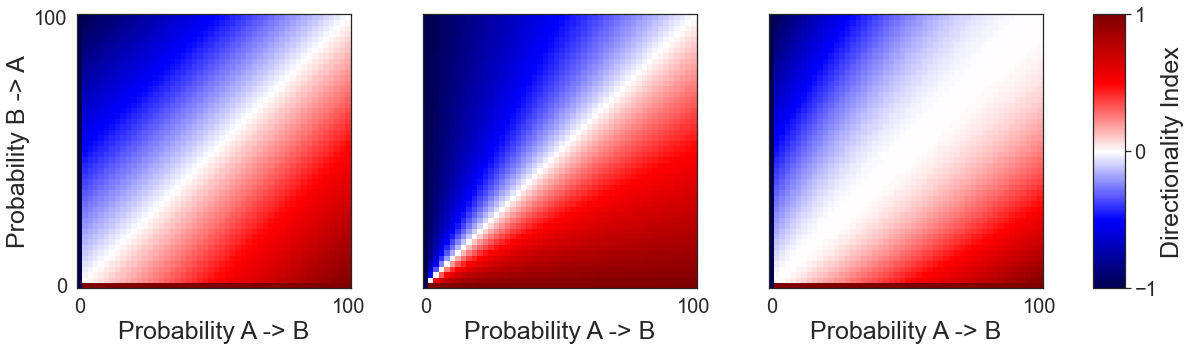

In [1643]:
fig = plt.figure(figsize=(17,5))
gs = fig.add_gridspec(1, 4, width_ratios=[10,10,10,1])
for i in range(3):
    ax = fig.add_subplot(gs[0, i])
    plt.pcolormesh(x,y,-c[i], cmap='seismic',shading='nearest')
    plt.xticks([0,1], ['0', '100'], fontsize=20)
    
    plt.xlabel('Probability A -> B', fontsize=25)
    if i ==0:
        plt.ylabel('Probability B -> A', fontsize=25)
        plt.yticks([0,1], ['0', '100'], fontsize=20)
    else:
        plt.yticks([])
    ax.set_aspect('equal', 'box')
        
cax = fig.add_subplot(gs[0, 3])
cbar = plt.colorbar(cax=cax, ticks=[-1, 0, 1])
plt.ylabel('Directionality Index', fontsize=25)
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
# cbar.ax.set_xticklabels(['-1','0','1'],fontsize=25)  # horizontal colorbar
plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Methods\BrainMapping\Sig_Cons\DI.svg')
plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Methods\BrainMapping\Sig_Cons\DI.jpg')
plt.show()

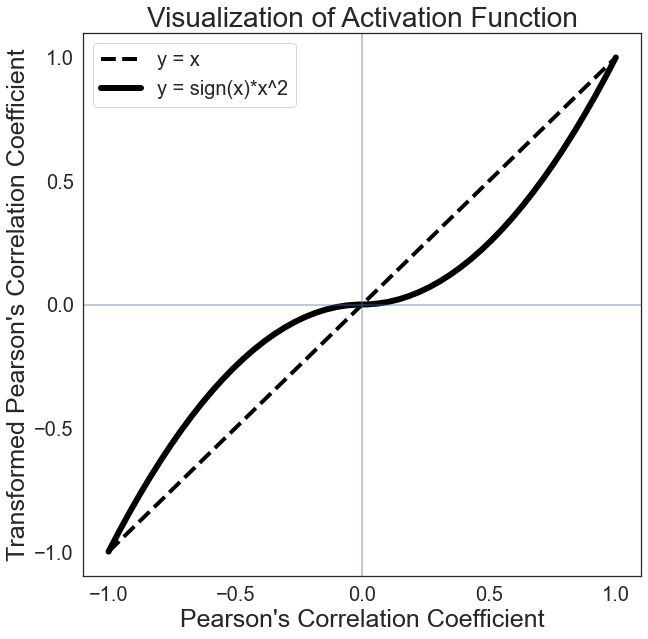

In [1626]:
x = np.linspace(-1,1)
y1 = x
y2 = np.sign(x)*x**2

plt.figure(figsize=(10,10))
plt.plot(x,y1, '--', color=[0,0,0], linewidth=4, label = 'y = x')
plt.plot(x,y2, color=[0,0,0], linewidth=6, label = 'y = sign(x)*x^2')
plt.ylim([-1.1, 1.1])
plt.legend(fontsize=20)
plt.xlim([-1.1, 1.1])
plt.xticks([-1, -0.5, 0, 0.5, 1], fontsize=20)
plt.yticks([-1, -0.5, 0, 0.5, 1], fontsize=20)
plt.axvline(0, alpha=0.5)
plt.axhline(0, alpha=0.5)
plt.xlabel("Pearson's Correlation Coefficient", fontsize=25)
plt.ylabel("Transformed Pearson's Correlation Coefficient", fontsize=25)
plt.title("Visualization of Activation Function", fontsize=28)
plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Methods\BrainMapping\Sig_trials\Act_func.svg')
plt.show()

In [ ]:
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Block\\BM_LL.npy'
if os.path.exists(M_dir_path):
    M_B_all = np.load(M_dir_path)
else:
    print('cal')
    M_B_all = np.zeros((int(np.max(con_trial.Block) + 1), len(labels_all), len(labels_all)))
    for b in np.unique(con_trial.Block).astype('int'):
        summ = con_trial[(con_trial.Sig == 2) & (con_trial.Block == b)]  # (con_trial.Sleep==s)&
        summ = summ.groupby(['Stim', 'Chan'], as_index=False)[['LL', 'd']].mean()
        # summ = summ[summ.Sig==1]
        t = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
        M = np.zeros((len(labels_all), len(labels_all)))
        M[:, :] = np.nan
        for sc in np.unique(summ.Stim).astype('int'):
            chan = summ.loc[summ.Stim == sc, 'Chan'].values.astype('int')
            LL = summ.loc[summ.Stim == sc, 'LL'].values
            M[sc, chan] = LL

        M_B_all[b, :, :] = M
        #M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)
        #M_resp = M_resp[ind,:]
        #M_resp = M_resp[:,ind]
        #ll = 'BM'+str(int(b)).zfill(2)#+', '+sleep_states[s]

        #plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 'LL',save= 1, circ = 1, group='Block')

        #plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 'LL',save= 0, circ = 1,vm = np.array([0,np.nanpercentile(M_B_all[M_B_all>0],95)]), group='block')
        # plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t,'LL', 1)
    np.save(M_dir_path, M_B_all)

In [ ]:
M_pearson = np.zeros((1,9))
M_B_all[np.isnan(M_B_all)] = 0
M_B_pear = np.ones((int(np.max(con_trial.Block) + 1), int(np.max(con_trial.Block) + 1)))
block_all = np.unique(con_trial.Block).astype('int')
for b1 in block_all:
    for b2 in block_all[block_all>b1]:
        M_pearson_c = np.zeros((1,9))
        
        M_B_pear[b1, b2] = np.corrcoef(M_B_all[b1, :, :].flatten(), M_B_all[b2, :, :].flatten())[0, 1]
        M_B_pear[b2, b1] = np.corrcoef(M_B_all[b1, :, :].flatten(), M_B_all[b2, :, :].flatten())[0, 1]
        s1 = np.bincount(con_trial.loc[con_trial.Block==b1, 'Sleep']).argmax()
        h1 = np.bincount(con_trial.loc[con_trial.Block==b1, 'Hour']).argmax()
        m1 = len(np.unique(con_trial.loc[con_trial.Block==b1, 'SleepState']))
        s2 = np.bincount(con_trial.loc[con_trial.Block==b2, 'Sleep']).argmax()
        h2 = np.bincount(con_trial.loc[con_trial.Block==b2, 'Hour']).argmax()
        m2 = len(np.unique(con_trial.loc[con_trial.Block==b2, 'SleepState']))

        M_pearson_c[0] = [b1,b2,M_B_pear[b1, b2],s1,s2,h1,h2, m1, m2]
        M_pearson = np.concatenate([M_pearson,M_pearson_c], 0)
# plot
plt.figure(figsize=(8, 8))
plt.pcolor(M_B_pear[:, :], cmap='hot', vmin=0.7, vmax=np.percentile(M_B_pear[:, :], 95))

In [ ]:
M_pearson = M_pearson[1:,:]
M_pear = pd.DataFrame(M_pearson, columns= ['A_Block', 'B_Block', 'Pearson', 'A_Sleep', 'B_Sleep', 'A_Hour', 'B_Hour', 'A_mix', 'B_mix'])

In [ ]:
M_pear.loc[M_pear.A_Sleep==2, 'A_Sleep'] = 3
M_pear.loc[M_pear.B_Sleep==2, 'B_Sleep'] = 3

In [ ]:
M_pear.insert(0,'Comp_Type', 'W-W')
M_pear.loc[(M_pear.B_Sleep==3)&(M_pear.A_Sleep==3), 'Comp_Type'] ='NREM-NREM'
M_pear.loc[(M_pear.B_Sleep==4)&(M_pear.A_Sleep==4), 'Comp_Type'] ='REM-REM'

M_pear.loc[(M_pear.B_Sleep==0)&(M_pear.A_Sleep==4), 'Comp_Type'] ='W-REM'
M_pear.loc[(M_pear.B_Sleep==4)&(M_pear.A_Sleep==0), 'Comp_Type'] ='W-REM'

M_pear.loc[(M_pear.B_Sleep==0)&(M_pear.A_Sleep==3), 'Comp_Type'] ='W-NREM'
M_pear.loc[(M_pear.B_Sleep==3)&(M_pear.A_Sleep==0), 'Comp_Type'] ='W-NREM'

M_pear.loc[(M_pear.B_Sleep==4)&(M_pear.A_Sleep==3), 'Comp_Type'] ='REM-NREM'
M_pear.loc[(M_pear.B_Sleep==3)&(M_pear.A_Sleep==4), 'Comp_Type'] ='REM-NREM'

In [ ]:
sns.catplot(x='Comp_Type', y= 'Pearson', kind='swarm', data=M_pear[(M_pear.A_mix==1)&(M_pear.B_mix==1)], aspect = 3)

In [ ]:
sns.catplot(x='Comp_Type', y= 'Pearson', kind='box', data=M_pear,height = 8, aspect = 3)
plt.title('Pearson of connectivity maps comparisons, main sleep state (mix possible)', fontsize=30)
plt.ylabel('Pearson Correlation', fontsize=25)
plt.xlabel('Comparison Type', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0.7, 1])

In [ ]:
M_pear.loc[M_pear.A_Sleep==2, 'A_Sleep'] = 3
M_pear.loc[M_pear.B_Sleep==2, 'B_Sleep'] = 3

In [ ]:
len(M_B_pear)
blocks_all = np.unique(con_trial.Block)
x_ax_block = np.zeros((len(M_B_pear),))
x_ticks_h = np.zeros((int(len(M_B_pear) / 5),))
labels_hour = []
k = 0
for i_b in range(len(M_B_pear)):
    if i_b in blocks_all:
        x_ax_block[i_b] = stimlist_hypno.loc[stimlist_hypno.stim_block == i_b, 'ix_chron'].values[0]
        if (np.mod(i_b, 5) == 0):
            x_ticks_h[k] = stimlist_hypno.loc[stimlist_hypno.stim_block == i_b, 'ix_chron'].values[0]
            h = int(np.floor(stimlist_hypno.loc[stimlist_hypno.stim_block == i_b, 'ix_h'].values[0]))
            labels_hour.append(str(h).zfill(2) + ':00')
            k = k + 1
    else:
        x_ax_block[i_b] = stimlist_hypno.loc[stimlist_hypno.stim_block == i_b + 1, 'ix_chron'].values[0] - 1
x_ticks_h = x_ticks_h[:len(labels_hour)]

In [ ]:
## figure
fig = plt.figure(figsize=(17, 18))
fig.patch.set_facecolor('xkcd:white')
k = 3
gs = fig.add_gridspec(2, 1, height_ratios=[1, 8])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax_h = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=[0, 0, 0], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0, :])
plt.fill_between(stimlist_hypno.ix_chron, stimlist_hypno.sleep, np.zeros((len(stimlist_hypno.ix_chron),)) - 1,
                 color=color_elab[0, :])
#plt.ylabel('score', fontsize=25)
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim([-1, 5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.axvspan(38.7, 40.7, color='black')
plt.tick_params(axis="y", labelsize=18)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])

ax = fig.add_subplot(gs[1, 0])  #, sharex=ax_h
cmap = plt.get_cmap('jet')
cmap.set_under('black')
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])
plt.axvspan(38.7, 40.7, color='black')
# cmap.set_bad('black')
# M_B_pear = np.ma.masked_equal(M_B_pear, 0)
plt.pcolor(x_ax_block, np.arange(len(M_B_pear)), M_B_pear, cmap=cmap, vmin=0.65, vmax=0.9)
plt.ylim([1, 69])
plt.yticks(fontsize=20)
plt.ylabel('Block Number', fontsize=20)
plt.xticks(x_ticks_h, labels_hour, fontsize=20)
plt.tight_layout()


##  unsupervised clustering

In [ ]:
import NMF_funcs as NMFf
from sklearn.decomposition import NMF

In [ ]:
metric = 'LL'
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Block\\BM_' + metric + '.npy'
M_Block = np.load(M_dir_path)


In [ ]:
# 1. vcotrize matrices
## nnmf
M_B_nmf = M_Block.reshape(len(M_Block), -1)
M_B_nmf = M_B_nmf.T
M_B_nmf[np.isnan(M_B_nmf)] = 0
M_B_nmf[M_B_nmf < 0] = 0

In [ ]:
M_B_nmf = M_B_nmf[:,1:]

In [ ]:
fig = plt.figure(figsize=(10,15))
plt.pcolor(M_B_nmf, vmin = 2, vmax= 10)

In [ ]:
fig = plt.figure(figsize=(10,15))
plt.pcolor(X, vmin = -2, vmax = 2)

### 1. euclidean distance

In [ ]:
import platform
from tslearn.clustering import TimeSeriesKMeans, KShape,KernelKMeans,silhouette_score


In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
tslearn.clustering.KShape(n_clusters=3, max_iter=100, tol=1e-06, n_init=1, verbose=False, random_state=None, init='random')[source]

In [ ]:
silhouette_score(X, labels, metric=None, sample_size=None, metric_params=None, n_jobs=None, verbose=0, random_state=None, **kwds)

In [ ]:
def ks_cluster(X, n=2,cluster_type = 'dtw'):
    X = np.expand_dims(X,-1)
    km_dba  = KShape(n_clusters=n).fit(X)
    # dtw
    cc      = km_dba.cluster_centers_
    y       = km_dba.predict(X)
    
    return cc[:, :, 0], y

In [ ]:
def dba_cluster(X, n=2,cluster_type = 'dtw'):
    X = np.expand_dims(X,-1)
    km_dba  = TimeSeriesKMeans(n_clusters=n, metric=cluster_type, max_iter=10, max_iter_barycenter=10, random_state=0).fit(X)
    # dtw
    cc      = km_dba.cluster_centers_
    y       = km_dba.predict(X)
    dist    = km_dba.transform(X)
    dist_cc = np.max(km_dba.transform(km_dba.cluster_centers_))
    return cc[:, :, 0], y, dist, dist_cc

In [ ]:
  W = np.zeros((X.shape[0], rank))
    X0 = np.delete(X, np.where(np.mean(X, 1) == 0)[0], 0)
    # run 5 it with mult
    model = NMF(n_components=rank, init='nndsvda', max_iter=10)
    W0 = model.fit_transform(X0)
    H0 = model.components_
    # run again with best solution of first model
    model = NMF(n_components=rank, init='custom', max_iter=it, solver='mu')
    W0 = model.fit_transform(X0, W=W0, H=H0)
    H = model.components_
    W[np.where(np.mean(X, 1) > 0)[0], :] = W0

In [ ]:
rk_sel = 1
score = 0
for rk in range(2,6):
    cc, y, dist, dist_cc = dba_cluster(X0, n=rk, cluster_type = cluster_type)
    #silhouette_score(X0, y)
    score_new = sklearn.metrics.calinski_harabasz_score(X0, y)
    if score_new > score:
        score = score_new
        rk_sel = rk


In [ ]:
X = M_B_nmf
X0 = np.delete(X, np.where(np.mean(X, 1) == 0)[0], 0)
X0 = scipy.stats.zscore(X0, axis=1)

In [ ]:
cluster_type = 'euclidean'

In [ ]:
rk_sel = 3

In [ ]:
y_all = np.zeros((len(X),))-1
cc, y, dist, dist_cc = dba_cluster(X0, n=rk_sel, cluster_type = cluster_type)
cc_mean = np.zeros_like(cc)
for i in range(rk_sel):
    cc_mean[i,:] = np.mean(X0[y==i,:],0)
y_all[np.where(np.mean(X, 1) > 0)[0]] = y

In [ ]:
y_all

In [ ]:
M_sleep_nmf = np.zeros((len(labels_all), len(labels_all)))
for val in range(rk_sel):
    M_nmf = np.array((y_all == val)).reshape(len(labels_all), len(labels_all))
    M_nmf = M_nmf * (val+1)
    M_sleep_nmf = M_sleep_nmf + M_nmf
#M_nmf = np.array(((W[:,0]/W[:,1])>3)).reshape(len(labels_all),len(labels_all))
#M_nmf = np.array(((W[:,0]/W[:,1])<0.8)).reshape(len(labels_all),len(labels_all))
M_sleep_nmf[M_t_resp[:, :, 1] == -1] = -1
M_sleep_nmf[M_t_resp[:, :, 1] == 0] = 0
M_resp = np.delete(np.delete(M_sleep_nmf, bad_all, 0), bad_all, 1)

M_resp = M_resp[ind, :]
M_resp = M_resp[:, ind]
#(M, labels,areas, label, t, method,save= 1, circ = 1, cmap='hot', group='block')
plot_BM(M_resp, labels_sel,areas_sel, 'NMF_sleep', 0,'change', 0, circ = 0, group='Sleep')
#plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 'sym',save= 1, circ = 0, group='General')

In [ ]:
fig = plt.figure(figsize=(17, 7))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle(cluster_type+ ' distance clustering: Mean of each connection within the cluster')
k = 3
gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax_h = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=[0, 0, 0], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0, :])
plt.fill_between(stimlist_hypno.ix_chron, stimlist_hypno.sleep, np.zeros((len(stimlist_hypno.ix_chron),)) - 1,
                 color=color_elab[0, :])
#plt.ylabel('score', fontsize=25)
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim([-1, 5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.axvspan(38.7, 40.7, color='black')
plt.tick_params(axis="y", labelsize=18)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])

ax = fig.add_subplot(gs[1, 0])  #, sharex=ax_h
for i in range(rk_sel):
    plt.plot(x_ax_block[1:], cc_mean[i], linewidth=4, label='Cluster ' + str(i + 1)+', n: '+str(np.sum(y==i)))
plt.xticks(x_ticks_h, labels_hour, fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('Mean connection activity', fontsize=20)
plt.yticks(fontsize=15)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])
plt.axvspan(38.7, 40.7, color='black')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.jpg')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.svg')
plt.show()

In [ ]:
fig = plt.figure(figsize=(17, 7))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle(cluster_type+' distance clustering: Cluster Center')
k = 3
gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax_h = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=[0, 0, 0], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0, :])
plt.fill_between(stimlist_hypno.ix_chron, stimlist_hypno.sleep, np.zeros((len(stimlist_hypno.ix_chron),)) - 1,
                 color=color_elab[0, :])
#plt.ylabel('score', fontsize=25)
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim([-1, 5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.axvspan(38.7, 40.7, color='black')
plt.tick_params(axis="y", labelsize=18)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])

ax = fig.add_subplot(gs[1, 0])  #, sharex=ax_h
for i in range(rk_sel):
    plt.plot(x_ax_block[1:], cc[i], linewidth=4, label='Cluster ' + str(i + 1)+', n: '+str(np.sum(y==i)))
plt.xticks(x_ticks_h, labels_hour, fontsize=20)
plt.legend(fontsize=15)
plt.ylabel(' Cluster Center', fontsize=20)
plt.yticks(fontsize=15)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])
plt.axvspan(38.7, 40.7, color='black')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.jpg')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.svg')
plt.show()

### 3. NMF

In [ ]:
def get_nnmf_Epi(X, rank, it=2000):
    # remove rows that are completly equal zero
    # model = NMF(n_components=rank, init='random', random_state=50, max_iter=it)
    # W = model.fit_transform(X)
    # H = model.components_
    W = np.zeros((X.shape[0], rank))
    X0 = np.delete(X, np.where(np.mean(X, 1) == 0)[0], 0)
    # run 5 it with mult
    model = NMF(n_components=rank, init='nndsvda', max_iter=10)
    W0 = model.fit_transform(X0)
    H0 = model.components_
    # run again with best solution of first model
    model = NMF(n_components=rank, init='custom', max_iter=it, solver='mu')
    W0 = model.fit_transform(X0, W=W0, H=H0)
    H = model.components_
    W[np.where(np.mean(X, 1) > 0)[0], :] = W0

    return W, W0, H

In [ ]:
## nnmf
M_B_nmf = M_Block.reshape(len(M_Block), -1)
M_B_nmf = M_B_nmf.T
M_B_nmf[np.isnan(M_B_nmf)] = 0
M_B_nmf[M_B_nmf < 0] = 0

In [ ]:
rk = 5
[W, W0, H] = get_nnmf_Epi(M_B_nmf, rk, it=2000)

In [ ]:
# X = M_B_nmf
# X0 = np.delete(X, np.where(np.mean(X, 1) == 0)[0], 0)

# scipy.stats.pearsonr(np.repeat(np.expand_dims(H[0],0),len(X0),0), X0)

In [ ]:
PC_mat = np.zeros((rk, len(M_B_nmf)))
for r in range(rk):
    for i in range(len(M_B_nmf)):
        c,_  = scipy.stats.pearsonr(H[r], M_B_nmf[i])
        PC_mat[r,i] = c
y = np.argmax(PC_mat,0)

In [ ]:
fig = plt.figure(figsize=(17, 7))
fig.patch.set_facecolor('xkcd:white')
plt.suptitle('NMF activiation functions')
k = 3
gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax_h = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=[0, 0, 0], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0, :])
plt.fill_between(stimlist_hypno.ix_chron, stimlist_hypno.sleep, np.zeros((len(stimlist_hypno.ix_chron),)) - 1,
                 color=color_elab[0, :])
#plt.ylabel('score', fontsize=25)
plt.yticks([0, 1, 2, 3, 4], ['Wake', 'N1', 'N2', 'N3', 'REM'])
plt.ylim([-1, 5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])
plt.axvspan(38.7, 40.7, color='black')
plt.tick_params(axis="y", labelsize=18)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])

ax = fig.add_subplot(gs[1, 0])  #, sharex=ax_h
for i in range(rk):
    plt.plot(x_ax_block, H[i], linewidth=4, label='H' + str(i + 1))
plt.xticks(x_ticks_h, labels_hour, fontsize=20)
plt.legend(fontsize=15)
plt.ylabel('H coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.xlim([np.min(np.floor(x_ax_block)) + 1.7, np.max(np.ceil(x_ax_block)) - 0.3])
plt.axvspan(38.7, 40.7, color='black')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.jpg')
#plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.svg')
plt.show()

In [ ]:
start = 0
for b in np.unique(con_trial.Block).astype('int'):
    h = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
    s = np.mean(con_trial.loc[
                    con_trial.Block == b, 'Sleep'])  # np.bincount(con_trial.loc[con_trial.Block==b, 'Sleep']).argmax()
    arr = np.zeros((1, rk + 3))
    arr[0, 0] = b
    arr[0, 1] = h
    arr[0, 2] = s > 0
    for i in range(rk):
        arr[0, 3 + i] = H[i, b]
    nmf_arr = pd.DataFrame(arr, columns=['Block', 'Hour', 'Sleep', 'H1', 'H2', 'H3', 'H4'])
    if start == 0:
        nmf_summary = nmf_arr
        start = 1
    else:
        nmf_summary = pd.concat([nmf_summary, nmf_arr])


In [ ]:
H_sleep = np.zeros((rk, 3))
for h, i in zip(['H1', 'H2', 'H3', 'H4'], np.arange(rk)):
    sns.catplot('Sleep', h, data=nmf_summary)
    d_NREM, p_NREM = scipy.stats.ttest_ind(nmf_summary.loc[(nmf_summary.Sleep == 0), h],
                                           nmf_summary.loc[(nmf_summary.Sleep == 1), h])
    H_sleep[i, 0] = i + 1
    if p_NREM < 0.05:
        H_sleep[i, 1] = -1 * np.sign(d_NREM)
        H_sleep[i, 2] = p_NREM

In [ ]:
H_sleep

In [ ]:
W_pref_z

In [ ]:
H_sleep = pd.DataFrame(H_sleep, columns=['H', 'Sleep_change', 'p'])
if len(np.where(H_sleep.Sleep_change == 0)[0]) == 0:
    val, n_sc = np.unique(H_sleep.Sleep_change, return_counts=True)
    val = val[(n_sc >= 2)]
    p = np.max(H_sleep.loc[(H_sleep.Sleep_change == val[0]), 'p'].values)
    H_sleep.loc[(H_sleep.Sleep_change == val[0]) & (H_sleep.p == p), 'Sleep_change'] = 0
# get connections assign to cluster
# W_z = scipy.stats.zscore(W, 0)
# W_pref_z = np.argmax(W_z, 1)
# #W_pref_z[np.max(W_z, 1) < 1] = np.where(H_sleep.Sleep_change == 0)[0][0]
# W_pref_z[np.max(W_z, 1) < 0] = -1
PC_mat = np.zeros((rk, len(M_B_nmf)))
for r in range(rk):
    for i in range(len(M_B_nmf)):
        c,_  = scipy.stats.pearsonr(H[r], M_B_nmf[i])
        PC_mat[r,i] = c
W_pref_z = np.argmax(PC_mat,0)
W_pref_z[np.mean(M_B_nmf, 1) == 0] = -1
H_sleep = pd.DataFrame(H_sleep, columns=['H', 'Sleep_change'])
#np.savez(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\NNMF\\nmf_rk3.npz', W, H, H_sleep, W_pref_z)

-1: no connection infos '
0: no connection
1: no change / stable
2: sleep decrease
3: sleep increase

In [ ]:
sleep_con_labels = ['Decrease', 'Stable', 'Increase']
sleep_con_val = np.arange(-1, 2)
sleep_plot_val = np.array([2, 1, 3])  # n

In [ ]:
y

In [ ]:
file_t_resp = path_patient_analysis + '\\' + folder + '\\data\\M_t_resp.npy'
M_t_resp = np.load(file_t_resp)

In [ ]:
def plot_BM_CR_trial_sig(M, labels, areas, label, t, method, save=1):
    time = str(t).zfill(2) + ':00'
    fig = plt.figure(figsize=(15, 15))
    vmin = 0
    vmax = 1
    if method == 'LL':
        vmin = 1
        vmax = np.min([15, np.percentile(M, 95)])
    axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])  # x, y, (start posiion), lenx, leny
    im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap='hot', vmin=vmin, vmax=vmax)
    plt.suptitle(label + ', ' + time + '-- ' + method)
    plt.xlim([-1.5, len(labels) - 0.5])
    plt.ylim([-0.5, len(labels) + 0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r = areas[i]
        axmatrix.add_patch(Rectangle((i - 0.5, len(labels) - 0.5), 1, 1, alpha=1,
                                     facecolor=color_regions[np.where(regions == r)[0][0]]))
        axmatrix.add_patch(
            Rectangle((-1.5, i - 0.5), 1, 1, alpha=1, facecolor=color_regions[np.where(regions == r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.04, 0.85, 0.08, 0.08])  # x, y, x_len, y_len
    circle1 = plt.Circle((0.5, 0.5), 0.4, color=CR_color.c[t], alpha=CR_color.a[t])
    plt.text(0.3, 0.3, time)
    plt.axis('off')
    axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)

    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')

    if save:
        plt.savefig(
            path_patient + '/Analysis/' + folder + '/' + cond_folder + '/figures/BM_' + method + '/BM_' + label + '.jpg')
        plt.savefig(
            path_patient + '/Analysis/' + folder + '/' + cond_folder + '/figures/BM_' + method + '/GIF/BM_' + label + '.jpg')
        plt.close(fig)  #plt.show()#
    else:
        plt.show()

In [ ]:
def plot_BM(M, labels, areas, label, t, method, save=1, circ=1, cmap='hot', group='block'):
    cmap_sym = ListedColormap(["#2b2b2b", "black", "#c34f2f", "#1e4e79"])
    cmap_binary = ListedColormap(["#2b2b2b", "black", "#bdd7ee"])
    cmap_LL = 'hot'
    cmap_Prob = 'afmhot'
    cmap_change = ListedColormap(
        ["#2b2b2b", "black", "white", "blue", "red"])  # ListedColormap(["blue", "white", "red"])
    cmap_Dir = 'bwr'

    cmap = locals()["cmap_" + method]

    M[np.isnan(M)] = -1

    fig = plt.figure(figsize=(15, 15))
    fig.patch.set_facecolor('xkcd:white')
    axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])  # x, y, (start posiion), lenx, leny
    if method == 'LL':
        cmap = copy.copy(plt.cm.get_cmap(cmap))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
        cmap.set_under('#2b2b2b')
        cmap.set_bad('black')
        M = np.ma.masked_equal(M, 0)
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, vmin=0, vmax=10)
    elif method == 'Prob':
        cmap = copy.copy(plt.cm.get_cmap(cmap))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
        cmap.set_under('black')
        cmap.set_bad('#2b2b2b')
        M = np.ma.masked_equal(M, -1)
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, vmin=0.1, vmax=0.95)
    elif method == 'Dir':
        cmap = copy.copy(plt.cm.get_cmap(cmap))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
        cmap.set_under('black')
        cmap.set_bad('white')
        M = np.ma.masked_equal(M, -20)
        mask = 1*(np.tri(M.shape[0],k=0)==0)
        M = np.ma.array(M, mask = mask)
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, vmin=-1, vmax=1)
    else:
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap)
    plt.suptitle(label + '-- ' + method)
    plt.xlim([-1.5, len(labels) - 0.5])
    plt.ylim([-0.5, len(labels) + 0.5])
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    for i in range(len(labels)):
        r = areas[i]
        axmatrix.add_patch(Rectangle((i - 0.5, len(labels) - 0.5), 1, 1, alpha=1,
                                     facecolor=color_regions[np.where(regions == r)[0][0]]))
        axmatrix.add_patch(
            Rectangle((-1.5, i - 0.5), 1, 1, alpha=1,
                      facecolor=color_regions[np.where(regions == r)[0][0]]))
    # Plot colorbar.

    if circ:
        time = str(t).zfill(2) + ':00'
        axcolor = fig.add_axes([0.04, 0.85, 0.08, 0.08])  # x, y, x_len, y_len
        circle1 = plt.Circle((0.5, 0.5), 0.4, color=CR_color.c[t], alpha=CR_color.a[t])
        plt.text(0.3, 0.3, time)
        plt.axis('off')
        axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)

In [ ]:
plot_BM(M, labels, areas, label, t, method, save=1, circ=1, cmap='hot', group='block')

In [ ]:
M_sleep_nmf = np.zeros((len(labels_all), len(labels_all)))
for lab, val, plot_val in zip(sleep_con_labels, sleep_con_val, sleep_plot_val):
    h = np.where(H_sleep.values[:, 1] == val)[0]

    M_nmf = np.array((W_pref_z == h)).reshape(len(labels_all), len(labels_all))
    M_nmf = M_nmf * plot_val
    M_sleep_nmf = M_sleep_nmf + M_nmf
#M_nmf = np.array(((W[:,0]/W[:,1])>3)).reshape(len(labels_all),len(labels_all))
#M_nmf = np.array(((W[:,0]/W[:,1])<0.8)).reshape(len(labels_all),len(labels_all))
M_sleep_nmf[M_t_resp[:, :, 1] == -1] = -1
M_sleep_nmf[M_t_resp[:, :, 1] == 0] = 0
M_resp = np.delete(np.delete(M_sleep_nmf, bad_all, 0), bad_all, 1)

M_resp = M_resp[ind, :]
M_resp = M_resp[:, ind]
#(M, labels,areas, label, t, method,save= 1, circ = 1, cmap='hot', group='block')
plot_BM(M_resp, labels_sel,areas_sel, 'NMF_sleep', 0,'change', 0, circ = 0, group='Sleep')
#plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 'sym',save= 1, circ = 0, group='General')

In [ ]:
plot_BM(M_resp, labels_sel, areas_sel, 'NMF_change', 1, 'change', 1, circ=0, group='Sleep')

In [ ]:
def plot_BM(M, labels, areas, label, t, method, save=1, circ=1, cmap='hot', group='block'):
    cmap_sym = ListedColormap(["#2b2b2b", "black", "#c34f2f", "#1e4e79"])
    cmap_binary = ListedColormap(["#2b2b2b", "black", "#bdd7ee"])
    cmap_LL = 'hot'
    cmap_Prob = 'afmhot'
    cmap_change = ListedColormap(
        ["#2b2b2b", "black", "green", "orange", "blue"])  # ListedColormap(["blue", "white", "red"])

    cmap = locals()["cmap_" + method]

    M[np.isnan(M)] = -1

    fig = plt.figure(figsize=(20, 20))
    fig.patch.set_facecolor('xkcd:white')
    axmatrix = fig.add_axes([0.15, 0.15, 0.7, 0.7])  # x, y, (start posiion), lenx, leny
    if method == 'LL':
        cmap = copy.copy(plt.cm.get_cmap(cmap))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
        cmap.set_under('#2b2b2b')
        cmap.set_bad('black')
        M = np.ma.masked_equal(M, 0)
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, vmin=0, vmax=10)
    elif method == 'Prob':
        cmap = copy.copy(plt.cm.get_cmap(cmap))  # cmap = copy.copy(mpl.cm.get_cmap(cmap))
        cmap.set_under('black')
        cmap.set_bad('#2b2b2b')
        M = np.ma.masked_equal(M, -1)
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap, vmin=0.1, vmax=0.95)
    else:
        im = axmatrix.matshow(M, aspect='auto', origin='lower', cmap=cmap)
    plt.suptitle(label + '-- ' + method)
    plt.xlim([-1.5, len(labels) - 0.5])
    plt.ylim([-0.5, len(labels) + 0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r = areas[i]
        axmatrix.add_patch(Rectangle((i - 0.5, len(labels) - 0.5), 1, 1, alpha=1,
                                     facecolor=color_regions[np.where(regions == r)[0][0]]))
        axmatrix.add_patch(
            Rectangle((-1.5, i - 0.5), 1, 1, alpha=1,
                      facecolor=color_regions[np.where(regions == r)[0][0]]))
    # Plot colorbar.

    if circ:
        time = str(t).zfill(2) + ':00'
        axcolor = fig.add_axes([0.04, 0.85, 0.08, 0.08])  # x, y, x_len, y_len
        circle1 = plt.Circle((0.5, 0.5), 0.4, color=self.CR_color.c[t], alpha=self.CR_color.a[t])
        plt.text(0.3, 0.3, time)
        plt.axis('off')
        axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)

    # plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')

    if save:
        plt.savefig(
            path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\' + group + '\\BM_' + method + '\\BM_' + label + '.jpg')
        # plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\figures/BM_LL\\BM_'+label+'.jpg')
        plt.close(fig)  # plt.show()#

    else:
        plt.show()

In [ ]:
for lab, val in zip(sleep_con_labels, sleep_con_val):
    h = np.where(H_sleep.values[:, 1] == val)[0]

    M_nmf = np.array((W_pref_z == h)).reshape(len(labels_all), len(labels_all))
    #M_nmf = np.array(((W[:,0]/W[:,1])>3)).reshape(len(labels_all),len(labels_all))
    #M_nmf = np.array(((W[:,0]/W[:,1])<0.8)).reshape(len(labels_all),len(labels_all))
    M_resp = np.delete(np.delete(M_nmf * (M_B_all[1] > 0), bad_all, 0), bad_all, 1)
    M_resp = M_resp * 1
    M_resp = M_resp[ind, :]
    M_resp = M_resp[:, ind]
    #(M, labels,areas, label, t, method,save= 1, circ = 1, cmap='hot', group='block')
    plot_BM_CR_trial_sig(M_resp, labels_sel, areas_sel, lab, t, 'binary', 1, circ=0, group='Sleep')
    #plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, t, 'sym',save= 1, circ = 0, group='General')

## Summary sleep


In [ ]:
day = np.unique(con_trial.Date)
t0 = np.min(con_trial.loc[(con_trial.Date == day[0]), 'Hour']).astype('int')
t1 = np.max(con_trial.loc[(con_trial.Date == day[-1]), 'Hour']).astype('int')
total_hour = (len(day) - 1) * 24 - (t0 - t1) + 1

if os.path.isfile(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv'):
    time_overview = pd.read_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv')
else:
    time_overview = np.zeros((total_hour, 5))
    b0 = np.min(con_trial.Block)
    time_overview[:, :] = np.nan
    time_overview[:, 0] = np.arange(total_hour)
    i = 0
    h0 = np.bincount(con_trial.loc[con_trial.Block == b0, 'Hour']).argmax()
    for b in np.unique(con_trial.Block):
        date = np.bincount(con_trial.loc[con_trial.Block == b, 'Date']).argmax()
        d = np.where(day == date)[0]
        i = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax() + d * 24 - h0
        time_overview[i, 1] = d
        time_overview[i, 2] = np.bincount(con_trial.loc[con_trial.Block == b, 'Hour']).argmax()
        time_overview[i, 3] = b
        time_overview[i, 4] = b
    time_overview = pd.DataFrame(time_overview[:, :4], columns=['ix', 'Day', 'Hour', 'Block'])
    time_overview.insert(3, 'Hour_label', 0)
    for b in np.unique(time_overview.Block):
        if b > 0:
            time_overview.loc[time_overview.Block == b, 'Hour_label'] = str(
                int(time_overview.loc[time_overview.Block == b, 'Hour'])).zfill(2) + ':00'

    time_overview.to_csv(path_patient_analysis + '/BrainMapping/CR/data/time_overview.csv', index=False, header=True)

# load hypnogram
file_hypno = path_patient_analysis + '/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
#stimlist_hypno.loc[(stimlist_hypno.ix_chron>30)&(stimlist_hypno.ix_chron<45), 'sleep'] = 0
for d in range(len(np.unique(stimlist_hypno.date))):
    stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d], 'ix_chron'] = stimlist_hypno.loc[
                                                                                                   stimlist_hypno.date ==
                                                                                                   np.unique(
                                                                                                       stimlist_hypno.date)[
                                                                                                       d], 'ix_h'] + d * 24
time_overview.insert(5, 'Hour_chron', time_overview.Hour + time_overview.Day * 24)
stimlist_hypno = stimlist_hypno[stimlist_hypno.stim_block > 0]
for p in np.unique(stimlist_hypno.Prot):
    stimlist_hypno.loc[stimlist_hypno.Prot == p, 'StimNum'] = stimlist_hypno.loc[
                                                                  stimlist_hypno.Prot == p, 'StimNum'] - np.min(
        stimlist_hypno.loc[stimlist_hypno.Prot == p, 'StimNum'])

In [ ]:
change_labels = ['unknown', 'no', 'stable', 'decrease', 'increase']

In [ ]:
change_labels = ['unknown', 'no', 'stable', 'decrease', 'increase']
for i in range(0, len(change_labels)):
    con_sleep.loc[con_sleep.prob_wake == i - 1, 'prob_wake'] = change_labels[i]
    con_sleep.loc[con_sleep.ttest_wake == i - 1, 'ttest_wake'] = change_labels[i]
color_sleep_change = dict(no="black", stable="gainsboro", decrease="blue", increase="red")

In [ ]:
for i in range(0, len(change_labels)):
    con_sleep.loc[con_sleep.prob_wake == i - 1, 'prob_wake'] = change_labels[i]
    con_sleep.loc[con_sleep.ttest_wake == i - 1, 'ttest_wake'] = change_labels[i]

In [ ]:
con_sleep

In [ ]:
color_sleep_change = dict(no="black", stable="gainsboro", decrease="blue", increase="red")

In [ ]:
# plt.figure(figsize=(10,5))
#plt.title('REM Effect')
for ss in ['NREM', 'REM']:
    sns.catplot(x='Dist', hue='ttest_wake', kind='count',
                data=con_sleep[(con_sleep.SleepState == ss) & (con_sleep.Sig == 1)], palette=color_sleep_change,
                height=8, legend=False)
    plt.legend(['Increase', 'Decrease', 'Stable'], fontsize=15)
    plt.title('Connections during ' + ss, fontsize=20)
    plt.xlabel('Connection Distance', fontsize=20)
    plt.ylabel('Number of Connections', fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(
        path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + ss + '_bar.jpg')
    plt.savefig(
        path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + ss + '_bar.svg')
    plt.close()

In [ ]:

for ss in ['NREM', 'REM']:
    fig = plt.figure(figsize=(10, 5))
    sns.histplot(x='d', multiple='stack', hue='ttest_wake',
                 data=con_sleep[(con_sleep.SleepState == ss) & (con_sleep.Sig == 1)],
                 palette=dict(unknown="grey", no="black", stable="white", decrease="blue", increase="red"))
    plt.legend(['Increase', 'Decrease', 'Stable'], fontsize=15)
    plt.title('Connections during ' + ss, fontsize=20)

    plt.xlabel('Connection Distance [mm]', fontsize=20)
    plt.ylabel('Number of Connections', fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(
        path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + ss + '_hist.jpg')
    plt.savefig(
        path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Sleep\\BM_change\\' + ss + '_hist.svg')
    plt.close(fig)

In [ ]:
sns.catplot(x='Stim_Area', y='Prob', hue='SleepState', kind='box', col='Dist', data=con_sleep[con_sleep.Sig == 1])

In [ ]:
labels_region[sc]

In [ ]:
ix_sleep = np.where(con_sleep.loc[(con_sleep.Stim == sc) & (con_sleep.Chan == rc), 'SleepState'] == 'Wake')[0]

In [ ]:
ix_sleep

In [ ]:
con_sleep

In [ ]:
sns.histplot(x='Dist', hue='sig_wake', multiple="stack",
             data=pd_summary[(pd_summary.Stim_region == 'Insula') & (pd_summary.SleepState == 'NREM')])

In [ ]:
sns.histplot(x='Dist', hue='sig_wake', multiple="stack",
             data=pd_summary[(pd_summary.Stim_region == 'Limbic') & (pd_summary.SleepState == 'NREM')])